# The Variational Autoencoder

## 1. Introduction

### 1.1 Overview

This notebook is a code tutorial on the variational autoencoder (VAE). There are three examples. First, we learn a simple bivariate Gaussian distribution. Second, we learn a data distribution drawn from two separate bivariate Gaussians. Third, we learn to reconstruct data from the MNIST dataset. Along the way, I hope to highlight some relevant implementation details.

You should be running this notebook with a Python 3 kernel. You also need to make sure that whatever environment you're using has installed the dependencies in the imports section (numpy and torch). There is no GPU support for this code, since it should comfortably run on your personal CPU, but note that any serious attempt at modeling large models using high-dimensional data will need to contend with device management.

### 1.2 References

D. P. Kingma and M. Welling, “Auto-encoding variational bayes,” *2nd International Conference on Learning Representations, ICLR 2014*, 2014.

## 2. Main Implementation

### 2.1 Imports and Utilities

This first block is a script that autoscrolls long cells (useful for viewing training progress without needing to manually scroll down every few seconds). Source: https://stackoverflow.com/questions/41539841/automatic-scroll-down-to-bottom-of-result-in-ipython-notebook

In [1]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };

    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }

        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [2]:
import copy
from math import pi as pi
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision
from torchvision.datasets import MNIST as MNIST
from typing import List, Optional, Tuple

In [3]:
class MLP(nn.Module):
    """Helper class for initializing MLPs."""
    
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        hidden_layer_sizes: List[int],
        nonlinearity: nn.Module,
        dropout: Optional[float] = None,
        batchnorm: Optional[bool] = False,
    ) -> None:
        """Initialize the MLP. Activations are softpluses.

        Parameters
        ----------
        input_dim : int
            Dimension of the input.
        output_dim : int
            Dimension of the output variable.
        hidden_layer_sizes : List[int]
            List of sizes of all hidden layers.
        nonlinearity : torch.nn.Module
            A the nonlinearity to use (must be a torch module).
        dropout : float, default=None
            Dropout probability if applied.
        batchnorm : bool, default=False
            Flag for applying batchnorm. NOTE: there are a plethora of ways
            to apply batchnorm layers. I chose post-activations.
        """
        super(MLP, self).__init__()

        assert type(input_dim) == int
        assert type(output_dim) == int
        assert type(hidden_layer_sizes) == list
        assert all(type(n) is int for n in hidden_layer_sizes)

        # building MLP
        self._mlp = nn.Sequential()
        self._mlp.add_module("fc0", nn.Linear(input_dim, hidden_layer_sizes[0]))
        self._mlp.add_module("act0", nonlinearity)
        if dropout is not None and 0.0 <= dropout and dropout <= 1.0:
            self._mlp.add_module("do0", nn.Dropout(p=dropout))
        if batchnorm:
            self._mlp.add_module("bn0", nn.BatchNorm1d(hidden_layer_sizes[0]))
        for i, (in_size, out_size) in enumerate(
            zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:]), 1
        ):
            self._mlp.add_module(f"fc{i}", nn.Linear(in_size, out_size))
            self._mlp.add_module(f"act{i}", nonlinearity)
            if dropout is not None and 0.0 <= dropout and dropout <= 1.0:
                self._mlp.add_module("do{i}", nn.Dropout(p=dropout))
            if batchnorm:
                self._mlp.add_module("bn{i}", nn.BatchNorm1d(out_size))
        self._mlp.add_module("fcout", nn.Linear(hidden_layer_sizes[-1], output_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass.

        Parameters
        ----------
        x : torch.Tensor, shape=(..., in_dim)
            Dimension of the input.

        Returns
        -------
        mlp_out : torch.Tensor, shape=(..., out_dim)
            Output tensor.
        """
        return self._mlp(x)

In [4]:
def gaussian_log_likelihood(mu: torch.Tensor, var: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    """Evaluates the log likelihood of diagonal-covariance Gaussian parameters given data.
    
    Parameters
    ----------
    mu : torch.Tensor, shape=(B, X)
        Batch of means of Gaussians.
    var : torch.Tensor, shape=(B, X)
        Batch of (diagonal) covariances of Gaussians.
    x : torch.Tensor, shape=(B, X)
        Batch of data.
        
    Returns
    -------
    ll : torch.Tensor, shape=(1)
        Batch-averaged log likelihood of the parameters.
    """
    B, X = x.shape
    ll = -torch.sum(torch.sum(0.5 * (torch.log(2 * pi * var) + (x - mu) ** 2 / var), dim=-1) + X) / B
    return ll

def gaussian_dkl(
    mu_1: torch.Tensor,
    var_1: torch.Tensor,
    mu_2: torch.Tensor = None,
    var_2: torch.Tensor = None
) -> torch.Tensor:
    """Computes the analytical KL divergence between two diagonal-covariance Gaussians.
    
    Consider two Gaussian distributions D_1 = N(mu_1, var_1) and D_2 = N(mu_2, var_2).
    This function will compute D_KL(D_1 || D_2). If the parameters of D_2 are none,
    then D_2 is assumed to be the standard normal distribution.
    
    Parameters
    ----------
    mu_1 : torch.Tensor, shape=(B, X)
        Mean of D_1.
    var_1 : torch.Tensor, shape=(B, X)
        Diagonal entries of covariance of D_1.
    mu_2 : torch.Tensor, shape=(B, X), default=None
        Mean of D_2. Optional.
    var_2 : torch.Tensor, shape=(B, X), default=None
        Diagonal entries of covariance of D_2. Optional.
        
    Returns
    -------
    dkl : torch.Tensor, shape=(1)
        The batch-averged KL divergence.
    """
    B, X = mu_1.shape
    if mu_2 is None or var_2 is None:
        dkl = 0.5 * torch.sum(torch.sum(-torch.log(var_1) + var_1 + mu_1 ** 2, dim=-1) - X) / B
    else:
        dkl = 0.5 * torch.sum(
            torch.sum(torch.log(var_2) - torch.log(var_1) + (var_1 + (mu_2 - mu_1) ** 2) / var_2, dim=-1) - X
        ) / B
    return dkl

### 2.2 VAE Code

This first VAE is for modeling some vanilla Gaussian distributions.

We choose the encoder and decoder distributions as diagonal covariance Gaussians like in the Kingma paper. The prior is fixed as the standard normal distribution. The choice of diagonal covariance Gaussians means that representing the distribution over some *n*-dimensional random variable, we simple output *2n* variables, *n* for the mean and *n* for the log-variances. We parameterize these distributions as multilayer perceptrons (MLPs).

Note that we choose our networks to output log-variances. This is because every valid (and non-degenerate) covariance matrix has strictly positive diagonal entries. We can therefore pass the outputs through an element-wise exponential to recover positive values, even if the network has negative outputs. This is an extremely common trick in learning when recovering positive values is required.

In [5]:
class VAE1(nn.Module):
    """Variational Autoencoder (VAE)."""
    
    def __init__(self, latent_dim: int, obs_dim: int) -> None:
        """Initialize a VAE for modeling continuous data.
        
        Parameters
        ----------
        latent_dim : int
            Dimension of the latent space. Denoted n in the code.
        obs_dim : int
            Dimension of the observation space. Denoted p in the code.
        """
        super(VAE1, self).__init__()
        
        # assigning dimensions
        self._latent_dim = latent_dim
        self._obs_dim = obs_dim
        
        # initializing networks
        self._encoder = MLP(
            obs_dim,
            2 * latent_dim,
            [16, 16, 16],
            nn.Softplus(beta=2),
        )
        self._decoder = MLP(
            latent_dim,
            2 * obs_dim,
            [16, 16, 16],
            nn.Softplus(beta=2),
        )
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass of the VAE.
        
        Parameters
        ----------
        x : torch.Tensor, shape=(B, p)
            Batch of input data.
            
        Returns
        -------
        mu_e : torch.Tensor, shape=(B, n)
            Batch of means of encodings of x.
        var_e : torch.Tensor, shape=(B, n)
            Batch of (diagonal) covariances of encodings of x.
        mu_d : torch.Tensor, shape=(B, p)
            Batch of means of reconstructions of x.
        var_d : torch.Tensor, shape=(B, p)
            Batch of (diagonal) covariances of reconstructions of x.
        """
        # shapes
        n = self._latent_dim
        p = self._obs_dim
        
        # encoder
        out_e = self._encoder(x)
        mu_e = out_e[..., :n]
        var_e = torch.exp(out_e[..., n:])
        
        # reparameterization
        z = self.reparameterize(mu_e, var_e)
        
        # decoder
        out_d = self._decoder(z)
        mu_d = out_d[..., :p]
        var_d = torch.exp(out_d[..., p:])
        
        return mu_e, var_e, mu_d, var_d
    
    def loss(
        self,
        x: torch.Tensor,
        mu_e: torch.Tensor,
        var_e: torch.Tensor,
        mu_d: torch.Tensor,
        var_d: torch.Tensor,
    ) -> torch.Tensor:
        """Compute the loss.
        
        Parameters
        ----------
        See docstring for forward().
        
        Returns
        -------
        loss : torch.Tensor, shape=(1)
            The VAE loss.
        """
        loss_recon = -gaussian_log_likelihood(mu_d, var_d, x)
        loss_dkl = gaussian_dkl(mu_e, var_e)
        loss = loss_recon + loss_dkl
        return loss
    
    def reparameterize(self, mu: torch.Tensor, var: torch.Tensor) -> torch.Tensor:
        """Execute the reparameterization trick.
        
        Parameters
        ----------
        mu : torch.Tensor, shape=(B, X)
            Batch of input means.
        var : torch.Tensor, shape=(B, X)
            Batch of input (diagonal) covariances.
            
        Returns
        -------
        y : torch.Tensor, shape=(B, X)
            Sample from N(mu, var)
        """
        eps = torch.randn_like(var)
        y = mu + torch.sqrt(var) * eps  # element-wise because of diagonal covariance
        return y
    
    def generate(self, num_samples: int) -> torch.Tensor:
        """Generate data.
        
        Parameters
        ----------
        num_samples : int
            Number of samples to generate.
        
        Returns
        -------
        x_gen : torch.Tensor, shape=(num_samples, p)
            Generated observations.
        """
        # shapes
        n = self._latent_dim
        p = self._obs_dim

        # generation
        z_gen = torch.randn(num_samples, n)  # drawing a sample from the latent prior
        out_d = self._decoder(z_gen)  # decoding the random sample
        mu_gen = out_d[..., :p]
        var_gen = torch.exp(out_d[..., p:])
        eps = torch.randn_like(var_gen)
        x_gen = mu_gen + torch.sqrt(var_gen) * eps
        
        return x_gen

This second VAE is for modeling single-channel images (namely, for MNIST data).

The encoder functions similarly as before - it parameterizes a diagonal-covariance multivariate Gaussian. However, the decoder in this implementation does not represent a probability distribution, but is instead a *deterministic* decoder with a sigmoid final layer. Some reasons for this choice:

1) The data are not continuous, but are instead *quantized* pixel values (normalized between 0 and 1). Therefore, we need a function with an appropriate domain of [0, 1]. This also means we will use a *binary cross-entropy* loss, which works on data with values between 0 and 1.

2) The aforementioned quantization makes it harder to cleanly define a probabilistic decoder for the image sampling problem. For work on this, look up work like PixelCNN (they use quantized logistic distributions). Since the point of this tutorial is demonstrating how a VAE works, I skimped out on this detail.

Finally, it is reasonable to use convolutional neural networks instead of MLPs since we're dealing with images. MNIST data are small enough to allow MLPs to train at a not-too-slow rate.

In [6]:
class VAE2(nn.Module):
    """Variational Autoencoder (VAE)."""
    
    def __init__(self, latent_dim: int, obs_dim: int) -> None:
        """Initialize a VAE for modeling LxL single channel images.
        
        Parameters
        ----------
        latent_dim : int
            Dimension of the latent space. Denoted n in the code.
        obs_dim : int
            Dimension of the observation space. Denoted p in the code.
            NOTE: we assume the data is flattened before encoding and
            decoding will return flattened data as well.
        """
        super(VAE2, self).__init__()
        
        # assigning dimensions
        self._latent_dim = latent_dim
        self._obs_dim = obs_dim
        
        # initializing networks
        self._encoder = MLP(
            obs_dim,
            2 * latent_dim,
            [256, 128],
            nn.Softplus(beta=2),
        )
        self._decoder = nn.Sequential(
            MLP(
                latent_dim,
                obs_dim,
                [128, 256],
                nn.Softplus(beta=2),
            ),
            nn.Sigmoid(),
        )
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward pass of the VAE.
        
        Parameters
        ----------
        x : torch.Tensor, shape=(B, C, sqrt(p), sqrt(p))
            Batch of input data (channel images).
            
        Returns
        -------
        mu_e : torch.Tensor, shape=(B, n)
            Batch of means of encodings of x.
        var_e : torch.Tensor, shape=(B, n)
            Batch of (diagonal) covariances of encodings of x.
        x_recon_flat : torch.Tensor, shape=(B, p)
            Batch of flattened reconstructions.
        """
        # shapes
        n = self._latent_dim
        p = self._obs_dim
        
        # encoder
        out_e = self._encoder(x.reshape(-1, p))
        mu_e = out_e[..., :n]
        var_e = torch.exp(out_e[..., n:]) + 1e-6  # regularization
        
        # reparameterization
        z = self.reparameterize(mu_e, var_e)
        
        # decoder
        x_recon_flat = self._decoder(z)
        return mu_e, var_e, x_recon_flat
    
    def loss(
        self,
        x: torch.Tensor,
        x_recon_flat: torch.Tensor,
        mu_e: torch.Tensor,
        var_e: torch.Tensor,
    ) -> torch.Tensor:
        """Compute the loss.
        
        Parameters
        ----------
        See docstring for forward().
        
        Returns
        -------
        loss : torch.Tensor, shape=(1)
            The VAE loss.
        """
        B = x.shape[0]
        loss_recon = F.binary_cross_entropy(x_recon_flat, x.reshape(-1, 784), reduction='sum') / B
        loss_dkl = gaussian_dkl(mu_e, var_e)
        loss = loss_recon + loss_dkl
        return loss
    
    def reparameterize(self, mu: torch.Tensor, var: torch.Tensor) -> torch.Tensor:
        """Execute the reparameterization trick for diagonal-covariance Gaussian.
        
        Parameters
        ----------
        mu : torch.Tensor, shape=(B, X)
            Batch of input means.
        var : torch.Tensor, shape=(B, X)
            Batch of input (diagonal) covariances.
            
        Returns
        -------
        y : torch.Tensor, shape=(B, X)
            Sample from N(mu, var)
        """
        eps = torch.randn_like(var)
        y = mu + torch.sqrt(var) * eps  # element-wise because of diagonal covariance
        return y
    
    def generate(self, num_samples: int) -> torch.Tensor:
        """Generate data.
        
        Parameters
        ----------
        num_samples : int
            Number of samples to generate.
        
        Returns
        -------
        x_gen : torch.Tensor, shape=(num_samples, sqrt(p), sqrt(p))
            Generated image data of proper shape.
        """
        # shapes
        n = self._latent_dim
        p = self._obs_dim
        L = int(np.sqrt(p))

        # generation
        z_gen = torch.randn(num_samples, n)  # drawing a sample from the latent prior
        x_gen_flat = self._decoder(z_gen)  # decoding the random sample
        if num_samples == 1:
            x_gen = x_gen_flat.reshape(L, L)
        else:
            x_gen = x_gen_flat.reshape(-1, L, L)
        
        return x_gen

### 2.3 Training/Evaluation Code

In [7]:
# training loop
def train(
    model: nn.Module,
    epochs: int,
    train_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: Optional[torch.optim.lr_scheduler.StepLR] = None,
    vae_type: int = 1,
    print_iter: int = 10,
    ckpt_path: str = None,
) -> Tuple[List[nn.Module], List[int]]:
    """Training loop.
    
    Parameters
    ----------
    model : nn.Module
        The model to train.
    epochs : int
        The number of training epochs.
    train_loader : torch.utils.data.DataLoader
        The data loader with training data.
    optimizer : torch.optim.Optimizer
        The optimizer.
    scheduler : Optional[torch.optim.lr_scheduler.StepLR]
        The learning rate scheduler. I suggest a step scheduler, but you can use any.
    vae_type : int, default=1
        Type of vae. Choices: {1, 2}
    print_iter : int, default=10
        Iterations between training printouts.
    ckpt_path : str, default=None
        Path to a checkpoint to load to continue training.
        
    Returns
    -------
    model_list : List[nn.Module]
        A list of snapshots of the model at each epoch of training.
    loss_list : List[int]
        A list of losses of the model at each epoch of training.
    """
    if ckpt_path is not None:
        model.load_state_dict(torch.load(ckpt_path))
        print('Loaded Checkpoint!')
    model.train()  # training mode
    
    iteration = 1
    model_list = []
    loss_list = []
    
    for epoch in range(epochs):
        for batch_idx, minibatch in enumerate(train_loader):
            optimizer.zero_grad()  # reset gradients

            # check model type
            if vae_type == 1:
                # gradient step
                mu_e, var_e, mu_d, var_d = model(minibatch)
                loss = model.loss(minibatch, mu_e, var_e, mu_d, var_d)
                
            elif vae_type == 2:
                minibatch = minibatch[0]  # tuple with label - we don't need the label
                mu_e, var_e, x_recon_flat = model(minibatch)
                loss = model.loss(minibatch, x_recon_flat, mu_e, var_e)
                
            else:
                raise NotImplementedError

            # update parameters
            loss.backward()
            optimizer.step()
                
            # printing training information every 100 iterations
            if iteration % print_iter == 0:
                print(f"Epoch: {epoch + 1}\tIteration: {iteration}\tLoss: {loss.item():.4f}")
            
            iteration = iteration + 1
            
        # advance the lr scheduler
        if scheduler is not None:
            scheduler.step()
        
        # update cached performance of the model
        model_list.append(copy.deepcopy(model))
        loss_list.append(loss.item())
    
    return model_list, loss_list

# model evaluation
def eval(
    model_list: List[nn.Module],
    loss_list: List[int],
    valid_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    vae_type: int = 1,
) -> None:
    """Evaluate the model at various stages of training.
    
    Parameters
    ----------
    See docstring of train().
    """
    epoch = 1
    for model in model_list:
        model.eval()  # set model to evaluation mode

        with torch.no_grad():
            # computing validation loss
            data = valid_loader.dataset
            
            # checking model type
            if vae_type == 1:
                # compute loss
                mu_e, var_e, mu_d, var_d = model(data)
                valid_loss = model.loss(data, mu_e, var_e, mu_d, var_d)
                print(f"Epoch {epoch} Average Validation Loss: {valid_loss.item():.4f}")

                # recovering reconstructed data samples
                eps_recon = torch.randn_like(var_d)
                x_hat = mu_d + torch.sqrt(var_d) * eps_recon
                valid_data_x = valid_loader.dataset[:, 0].numpy()
                valid_data_y = valid_loader.dataset[:, 1].numpy()

                # generating data
                num_valid_pts = valid_data_x.shape[0]
                x_gen = model.generate(num_valid_pts)

                # plotting data
                plt.scatter(valid_data_x, valid_data_y, c='r', s=5)
                plt.scatter(x_hat[:, 0], x_hat[:,1], c='b', s=5)
                plt.scatter(x_gen[:, 0], x_gen[:,1], c='g', s=5)
                plt.title(f"Data, Reconstructions, and Samples: Epoch {epoch}")

                # plot style
                plt.xlabel('x1')
                plt.ylabel('x2')
                plt.legend(
                    ['Validation Data', 'Reconstructed Data', 'Generated Data'],
                    bbox_to_anchor=(1.04,1),
                    loc="upper left",
                )
                ax = plt.gca()
                plt.axis('square')
                ax.set_aspect(1./ax.get_data_ratio())
                ax.margins(0.1)
                plt.show()
                
            elif vae_type == 2:
                valid_data = data.data.float() / 255.0  # normalizing the pixels
                
                # compute loss
                mu_e, var_e, x_recon_flat = model(valid_data)
                valid_loss = model.loss(valid_data, x_recon_flat, mu_e, var_e)
                print(f"Epoch {epoch} Average Validation Loss: {valid_loss.item():.4f}")

                example_img = valid_data.reshape(-1, 28, 28)[0]  # specific example to reconstruct
                _, _, x_recon_flat = model(example_img)
                x_recon = x_recon_flat.reshape(28, 28)
                x_gen = model.generate(1)
                
                # plots
                fig = plt.figure()
                plt.suptitle(f"Epoch {epoch}", fontsize=14)
                ax1 = fig.add_subplot(131)
                ax2 = fig.add_subplot(132)
                ax3 = fig.add_subplot(133)
                ax1.imshow(example_img.numpy(), cmap="gray")
                ax1.set_title('Validation Sample')
                ax2.imshow(x_recon.numpy(), cmap="gray")
                ax2.set_title('Reconstructed Sample')
                ax3.imshow(x_gen.numpy(), cmap="gray")
                ax3.set_title('Generated Sample')
                plt.tight_layout()
                
            else:
                raise NotImplementedError
            epoch = epoch + 1
            
    # plotting loss curve
    losses = np.array(loss_list)
    plt.figure()
    plt.plot(losses)
    plt.title("Loss Over Time")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

## 3. Example 1: Learning a Multivariate Gaussian

This first example is simple: learn the distribution of data drawn from a bivariate Gaussian distribution. If you are jumping between running code in different sections, make sure to run all the code in this section from the start, since some variables are shared in the namespace.

### 3.1 Generating Data

In [8]:
# dataset statistics
obs_dim = 2
mu_data = torch.Tensor([2.0, 5.0])
cov_data = torch.Tensor(
    [[15.0, -10.0],
     [-10.0, 10.0]]
)
L_data = torch.cholesky(cov_data)

# generating training and validation sets
num_train_pts = 1000
num_valid_pts = 1000

eps_train = torch.randn(2, num_train_pts)
eps_valid = torch.randn(2, num_valid_pts)

train_data_ex1 = mu_data + (L_data @ eps_train).transpose(-1, -2)
valid_data_ex1 = mu_data + (L_data @ eps_valid).transpose(-1, -2)

### 3.2 Training Settings

You should play around with the settings in this section. I choose the ADAM optimizer and a step learning scheduler, so the hyperparameters will correspondingly only be appropriate for those choices. As is convention, the reparameterization trick is coded to produce only one sample, so this is not a tunable hyperparameter.

In [9]:
# hyperparameters
latent_dim = 2
batch_size = 32
epochs = 100
lr = 1e-2  # initial learning ratex_mean = vae_2d.generate(z_mu)
step_size = 50  # steps per decay for lr scheduler
gamma = 0.9  # multiplicative decay for lr scheduler

Don't mess with the code in this section unless you want to change the optimizer or LR scheduler.

In [10]:
# preparing dataloaders, optimizer, and scheduler
model_ex1 = VAE1(latent_dim, obs_dim)
train_loader_ex1 = torch.utils.data.DataLoader(
    train_data_ex1,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
valid_loader_ex1 = torch.utils.data.DataLoader(
    valid_data_ex1,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
optimizer_ex1 = optim.Adam(model_ex1.parameters(), lr=lr)
scheduler_ex1 = optim.lr_scheduler.StepLR(optimizer=optimizer_ex1, step_size=step_size, gamma=gamma)

### 3.3 Training

Run this cell to train the model.

In [11]:
model_list_ex1, loss_list_ex1 = train(
    model_ex1,
    epochs,
    train_loader_ex1,
    optimizer_ex1,
    scheduler=scheduler_ex1
)

Epoch: 1	Iteration: 10	Loss: 11.6590
Epoch: 1	Iteration: 20	Loss: 8.2862
Epoch: 1	Iteration: 30	Loss: 8.1804
Epoch: 2	Iteration: 40	Loss: 7.6865
Epoch: 2	Iteration: 50	Loss: 7.6178
Epoch: 2	Iteration: 60	Loss: 8.0196
Epoch: 3	Iteration: 70	Loss: 7.7028
Epoch: 3	Iteration: 80	Loss: 7.1947
Epoch: 3	Iteration: 90	Loss: 7.3829
Epoch: 4	Iteration: 100	Loss: 8.0363
Epoch: 4	Iteration: 110	Loss: 7.1781
Epoch: 4	Iteration: 120	Loss: 7.4122
Epoch: 5	Iteration: 130	Loss: 7.2308
Epoch: 5	Iteration: 140	Loss: 7.3319
Epoch: 5	Iteration: 150	Loss: 7.4921
Epoch: 6	Iteration: 160	Loss: 7.3596
Epoch: 6	Iteration: 170	Loss: 7.4024
Epoch: 6	Iteration: 180	Loss: 7.7014
Epoch: 7	Iteration: 190	Loss: 7.3471
Epoch: 7	Iteration: 200	Loss: 7.4368
Epoch: 7	Iteration: 210	Loss: 7.1895
Epoch: 8	Iteration: 220	Loss: 7.3153
Epoch: 8	Iteration: 230	Loss: 7.4542
Epoch: 8	Iteration: 240	Loss: 7.0291
Epoch: 9	Iteration: 250	Loss: 7.3222
Epoch: 9	Iteration: 260	Loss: 7.6095
Epoch: 9	Iteration: 270	Loss: 7.3683
Epoch: 10

Epoch: 70	Iteration: 2160	Loss: 7.0214
Epoch: 70	Iteration: 2170	Loss: 6.8165
Epoch: 71	Iteration: 2180	Loss: 6.8790
Epoch: 71	Iteration: 2190	Loss: 6.6758
Epoch: 71	Iteration: 2200	Loss: 6.5895
Epoch: 72	Iteration: 2210	Loss: 7.2355
Epoch: 72	Iteration: 2220	Loss: 6.7750
Epoch: 72	Iteration: 2230	Loss: 6.8744
Epoch: 73	Iteration: 2240	Loss: 7.1280
Epoch: 73	Iteration: 2250	Loss: 7.1628
Epoch: 73	Iteration: 2260	Loss: 6.7475
Epoch: 74	Iteration: 2270	Loss: 7.1849
Epoch: 74	Iteration: 2280	Loss: 6.5532
Epoch: 74	Iteration: 2290	Loss: 7.3672
Epoch: 75	Iteration: 2300	Loss: 6.8401
Epoch: 75	Iteration: 2310	Loss: 6.7626
Epoch: 75	Iteration: 2320	Loss: 6.4442
Epoch: 76	Iteration: 2330	Loss: 6.9652
Epoch: 76	Iteration: 2340	Loss: 6.7349
Epoch: 76	Iteration: 2350	Loss: 6.7338
Epoch: 77	Iteration: 2360	Loss: 7.5768
Epoch: 77	Iteration: 2370	Loss: 6.8503
Epoch: 77	Iteration: 2380	Loss: 6.6618
Epoch: 78	Iteration: 2390	Loss: 6.5182
Epoch: 78	Iteration: 2400	Loss: 7.0092
Epoch: 78	Iteration: 2410

### 3.4 Evaluation

Run this code to evaluate the model and see the progress it made during training. The reconstructed samples show the ability of the VAE to autoencode: to recreate the data once given. The generated samples show the ability of the VAE to generate samples: to reproduce the data distribution without seeing the validation data. You may need to uncheck "Auto-Scroll-To-Bottom" to scroll up and see earlier plots.

Epoch 1 Average Validation Loss: 7.8959


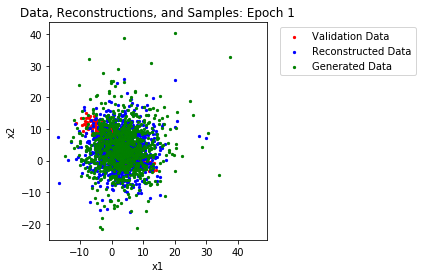

Epoch 2 Average Validation Loss: 7.4481


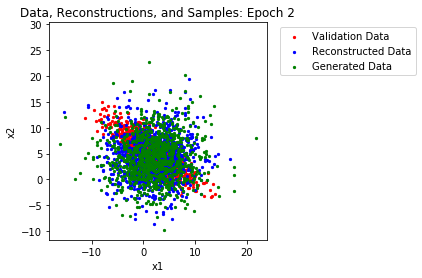

Epoch 3 Average Validation Loss: 7.3838


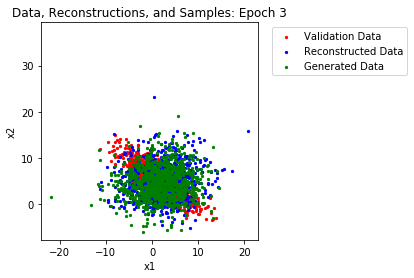

Epoch 4 Average Validation Loss: 7.3419


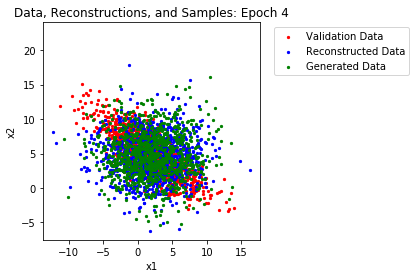

Epoch 5 Average Validation Loss: 7.3473


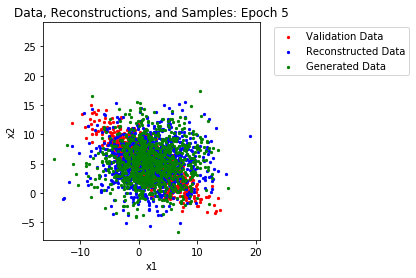

Epoch 6 Average Validation Loss: 7.3668


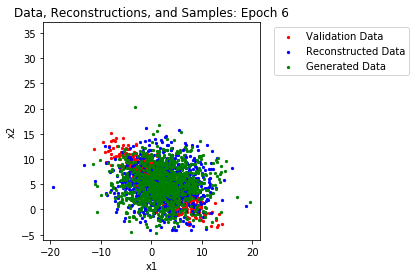

Epoch 7 Average Validation Loss: 7.3593


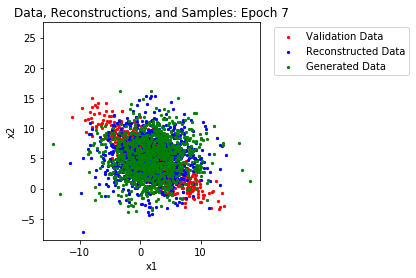

Epoch 8 Average Validation Loss: 7.3444


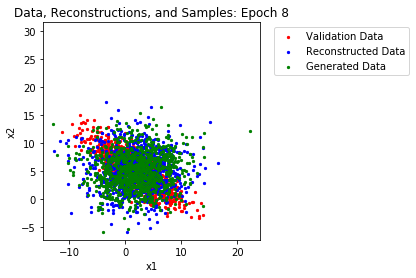

Epoch 9 Average Validation Loss: 7.3556


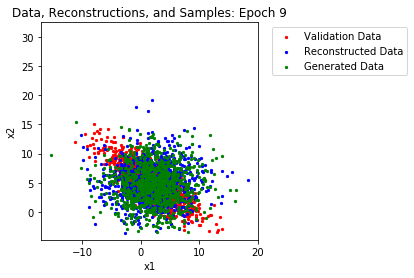

Epoch 10 Average Validation Loss: 7.3433


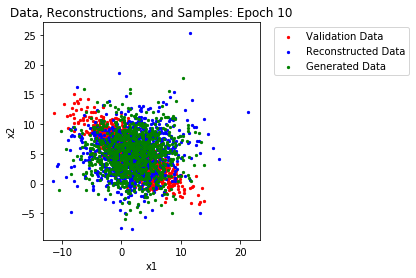

Epoch 11 Average Validation Loss: 7.3389


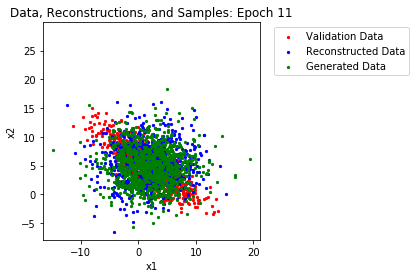

Epoch 12 Average Validation Loss: 7.3331


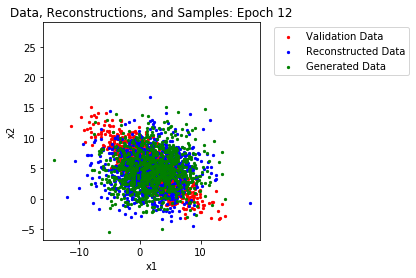

Epoch 13 Average Validation Loss: 7.3664


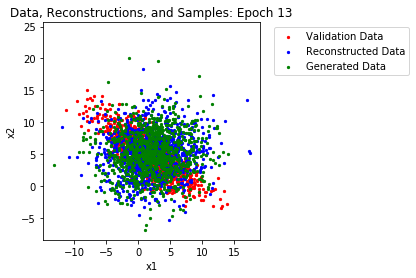

Epoch 14 Average Validation Loss: 7.3444


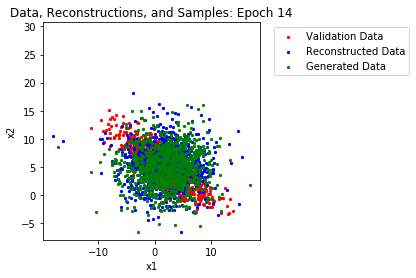

Epoch 15 Average Validation Loss: 7.3576


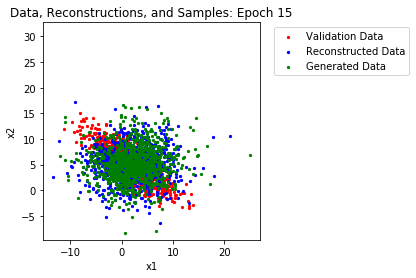

Epoch 16 Average Validation Loss: 7.3460


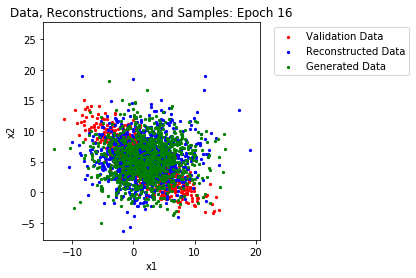

Epoch 17 Average Validation Loss: 7.3556


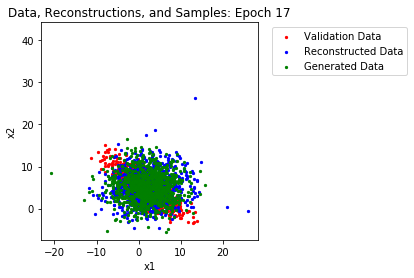

Epoch 18 Average Validation Loss: 7.3512


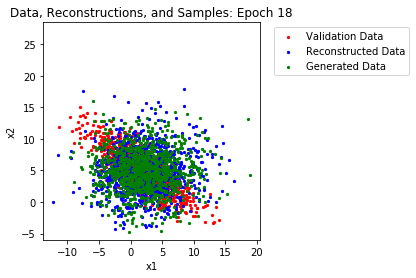

Epoch 19 Average Validation Loss: 7.3635


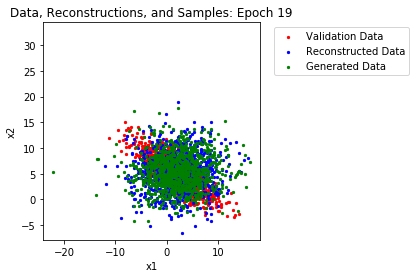

Epoch 20 Average Validation Loss: 7.3496


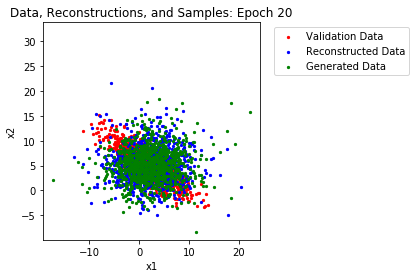

Epoch 21 Average Validation Loss: 7.3530


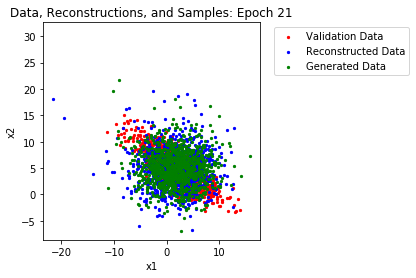

Epoch 22 Average Validation Loss: 7.3036


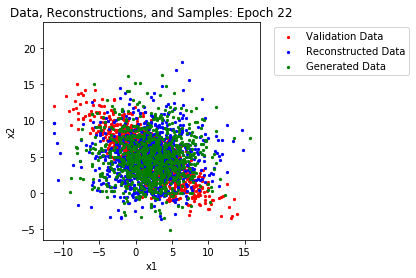

Epoch 23 Average Validation Loss: 7.3400


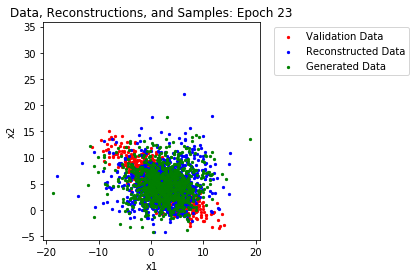

Epoch 24 Average Validation Loss: 7.3123


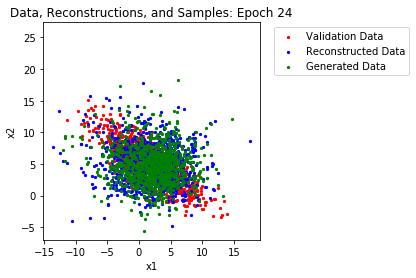

Epoch 25 Average Validation Loss: 7.2911


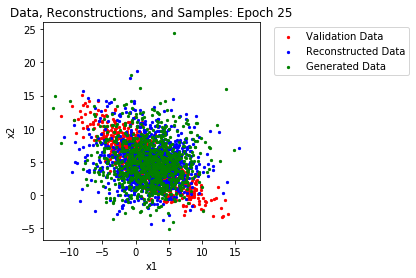

Epoch 26 Average Validation Loss: 7.2813


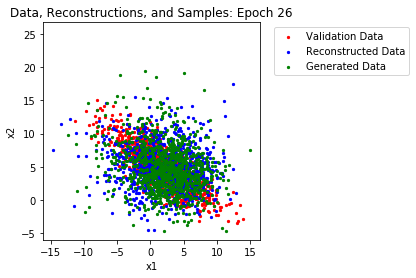

Epoch 27 Average Validation Loss: 7.1654


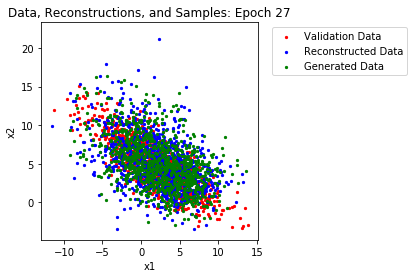

Epoch 28 Average Validation Loss: 7.0087


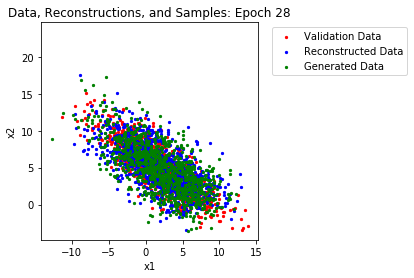

Epoch 29 Average Validation Loss: 7.0409


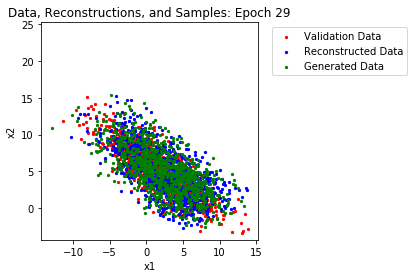

Epoch 30 Average Validation Loss: 6.9295


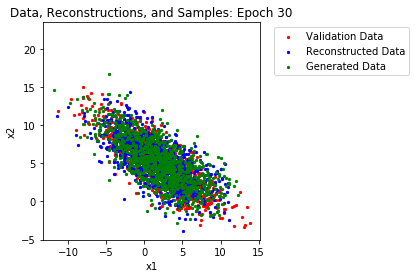

Epoch 31 Average Validation Loss: 6.9368


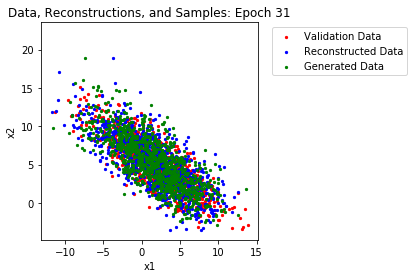

Epoch 32 Average Validation Loss: 7.0661


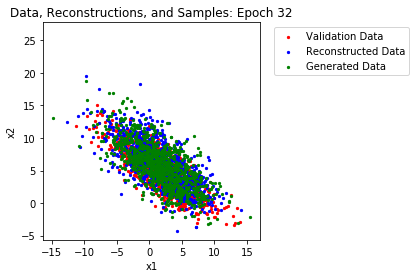

Epoch 33 Average Validation Loss: 7.0877


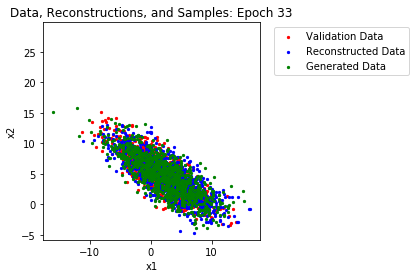

Epoch 34 Average Validation Loss: 6.9466


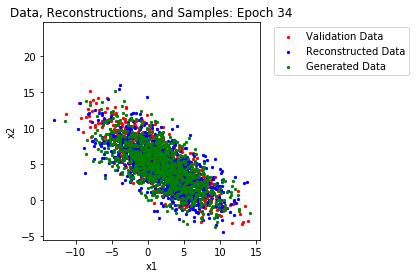

Epoch 35 Average Validation Loss: 6.9019


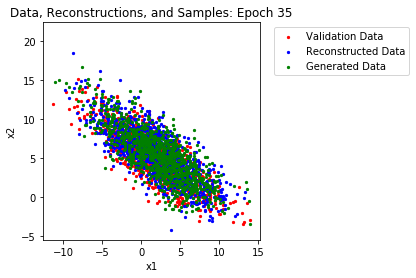

Epoch 36 Average Validation Loss: 6.8742


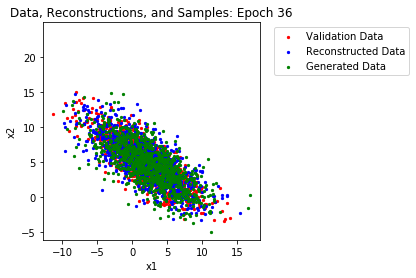

Epoch 37 Average Validation Loss: 7.0194


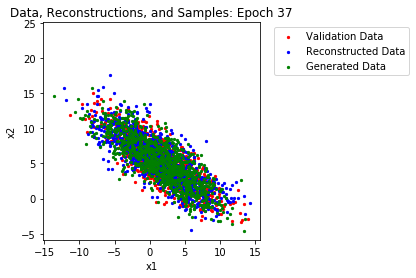

Epoch 38 Average Validation Loss: 6.8935


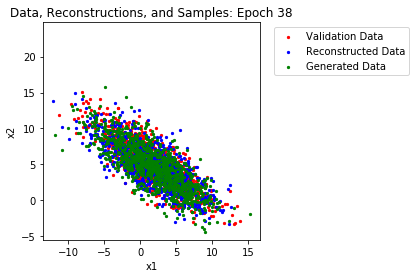

Epoch 39 Average Validation Loss: 6.8685


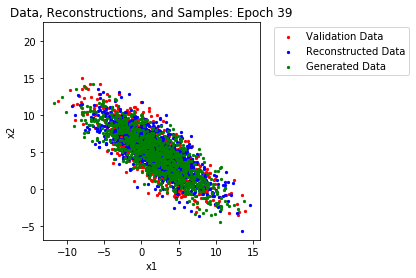

Epoch 40 Average Validation Loss: 6.8853


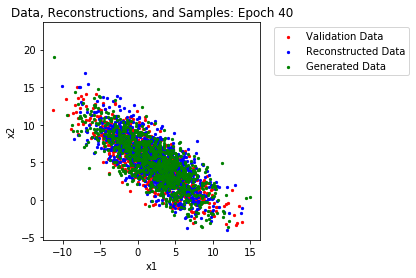

Epoch 41 Average Validation Loss: 6.9200


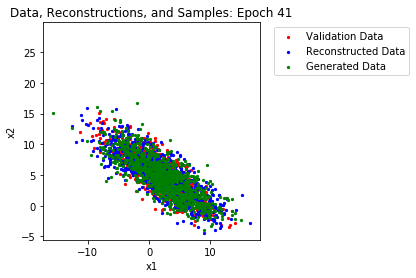

Epoch 42 Average Validation Loss: 6.9025


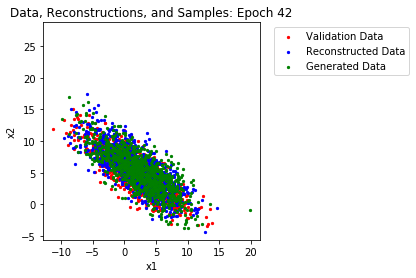

Epoch 43 Average Validation Loss: 6.9094


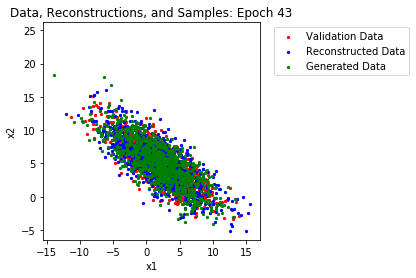

Epoch 44 Average Validation Loss: 6.8662


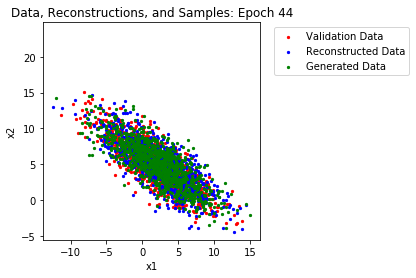

Epoch 45 Average Validation Loss: 6.9344


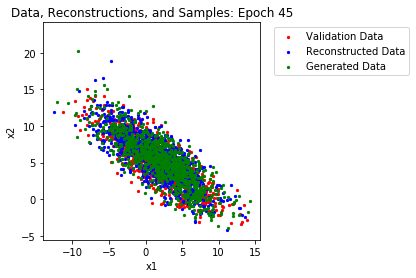

Epoch 46 Average Validation Loss: 6.9830


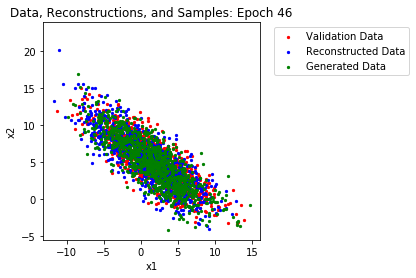

Epoch 47 Average Validation Loss: 6.9178


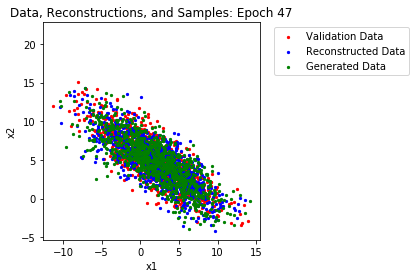

Epoch 48 Average Validation Loss: 7.0540


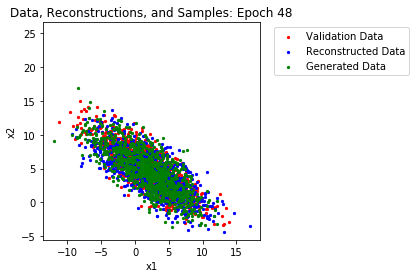

Epoch 49 Average Validation Loss: 6.9531


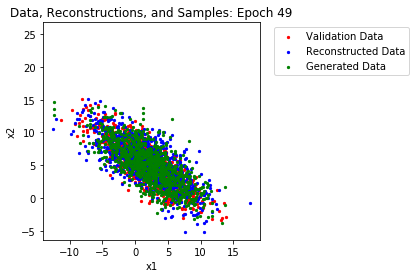

Epoch 50 Average Validation Loss: 6.8726


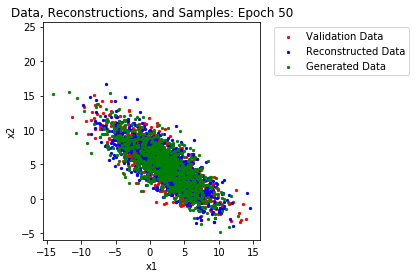

Epoch 51 Average Validation Loss: 6.8654


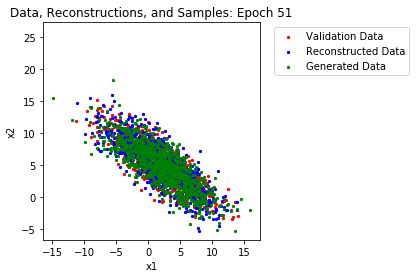

Epoch 52 Average Validation Loss: 6.8872


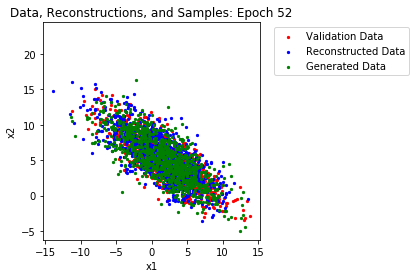

Epoch 53 Average Validation Loss: 6.8669


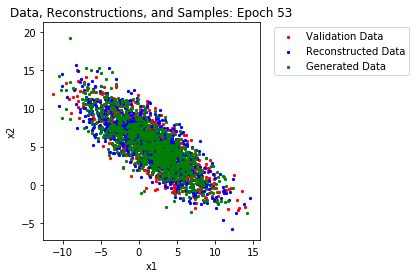

Epoch 54 Average Validation Loss: 6.9580


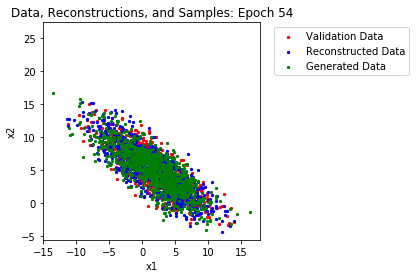

Epoch 55 Average Validation Loss: 6.8455


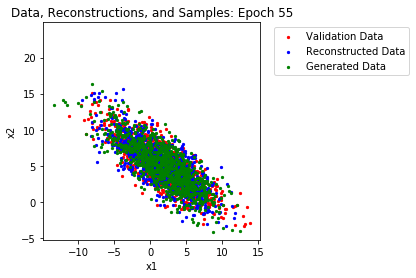

Epoch 56 Average Validation Loss: 6.9161


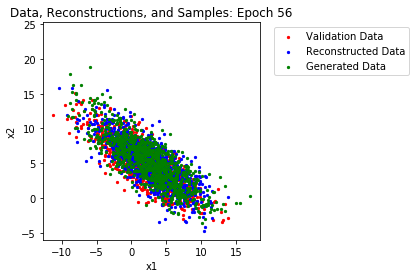

Epoch 57 Average Validation Loss: 6.9267


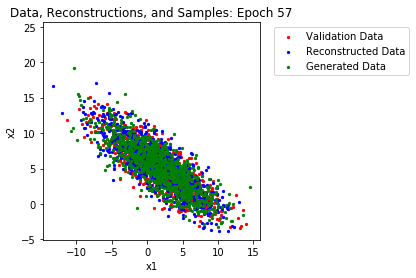

Epoch 58 Average Validation Loss: 6.9021


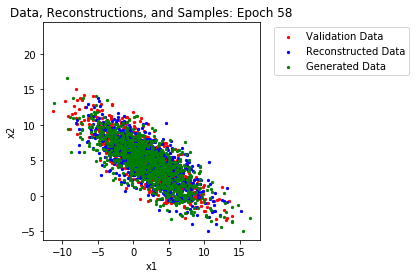

Epoch 59 Average Validation Loss: 6.8709


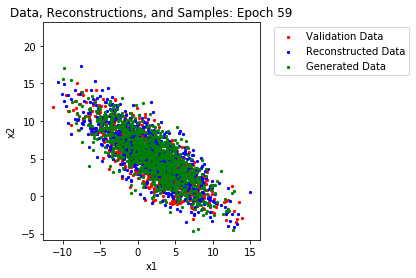

Epoch 60 Average Validation Loss: 6.9236


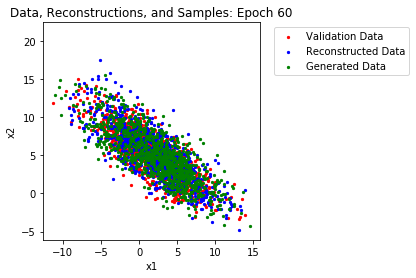

Epoch 61 Average Validation Loss: 6.8554


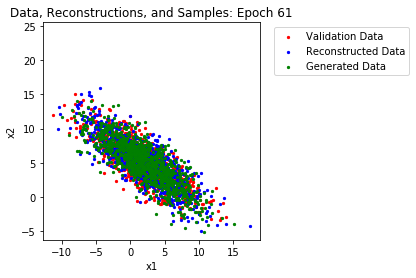

Epoch 62 Average Validation Loss: 6.8920


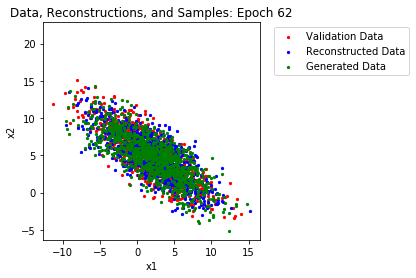

Epoch 63 Average Validation Loss: 6.8844


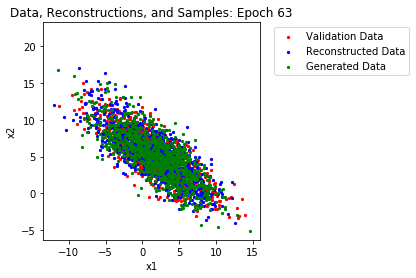

Epoch 64 Average Validation Loss: 6.8811


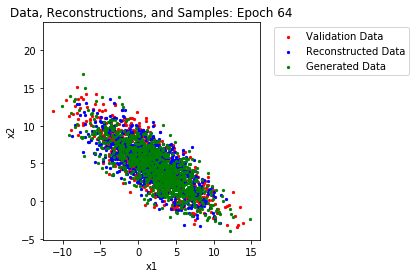

Epoch 65 Average Validation Loss: 6.8598


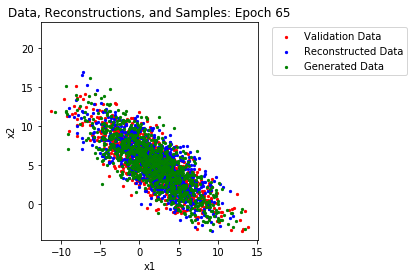

Epoch 66 Average Validation Loss: 6.8635


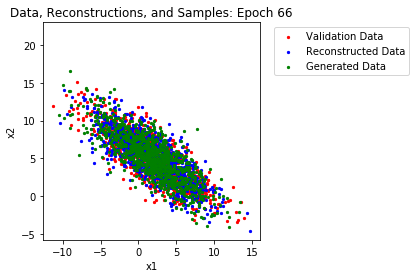

Epoch 67 Average Validation Loss: 6.8162


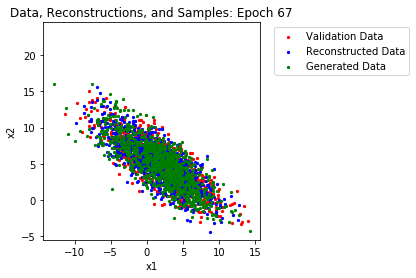

Epoch 68 Average Validation Loss: 6.9362


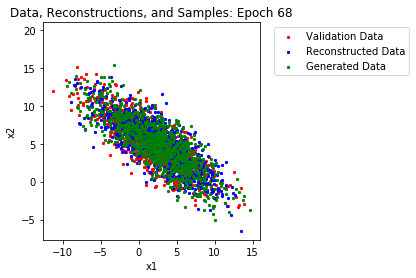

Epoch 69 Average Validation Loss: 6.8852


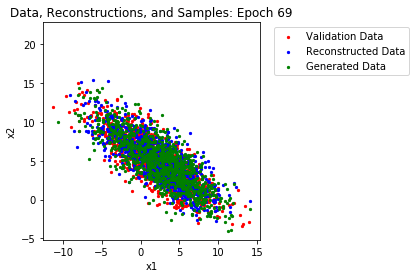

Epoch 70 Average Validation Loss: 6.8213


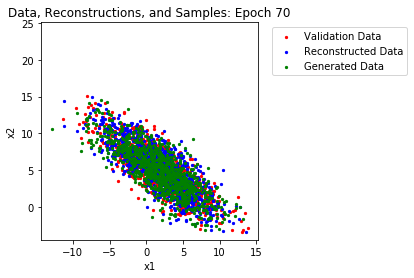

Epoch 71 Average Validation Loss: 6.8775


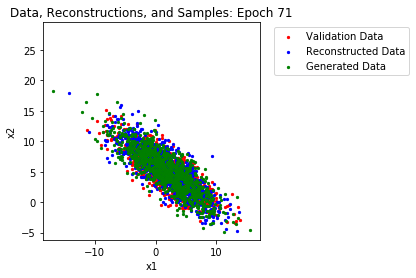

Epoch 72 Average Validation Loss: 6.8624


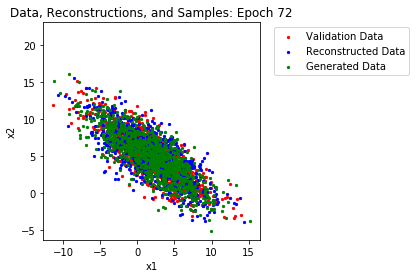

Epoch 73 Average Validation Loss: 6.8307


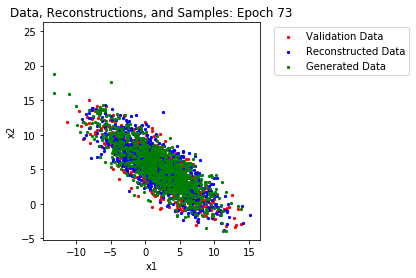

Epoch 74 Average Validation Loss: 6.8318


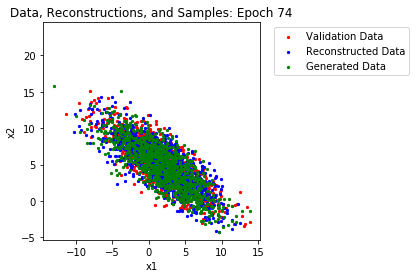

Epoch 75 Average Validation Loss: 6.8661


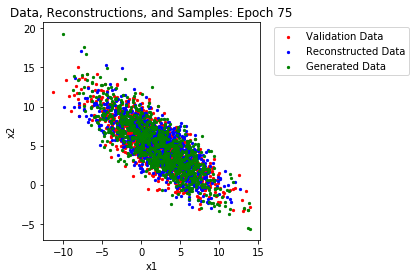

Epoch 76 Average Validation Loss: 6.9178


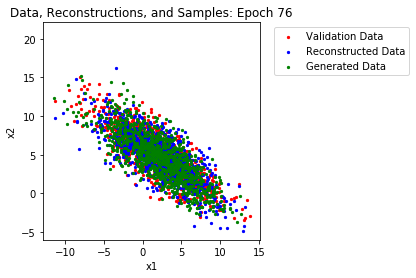

Epoch 77 Average Validation Loss: 6.8301


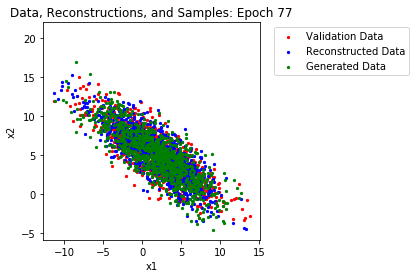

Epoch 78 Average Validation Loss: 6.8641


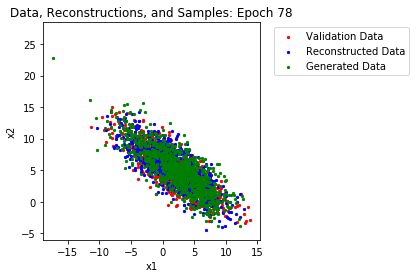

Epoch 79 Average Validation Loss: 6.9102


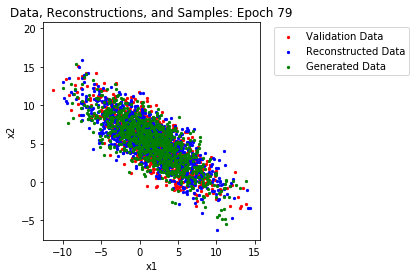

Epoch 80 Average Validation Loss: 6.8911


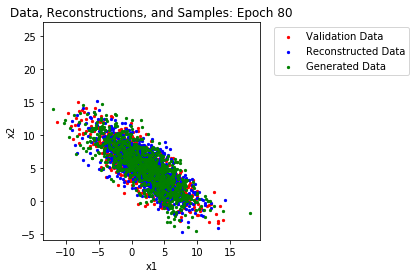

Epoch 81 Average Validation Loss: 6.8167


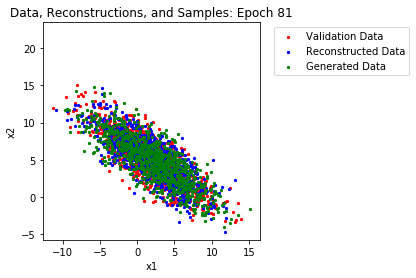

Epoch 82 Average Validation Loss: 6.8594


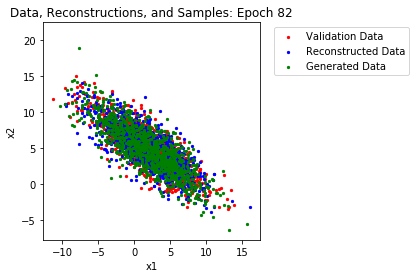

Epoch 83 Average Validation Loss: 6.8622


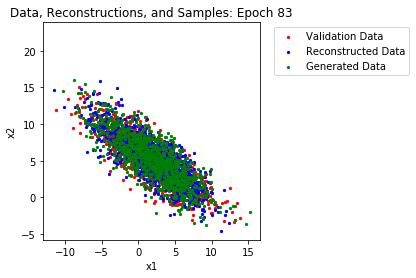

Epoch 84 Average Validation Loss: 6.8478


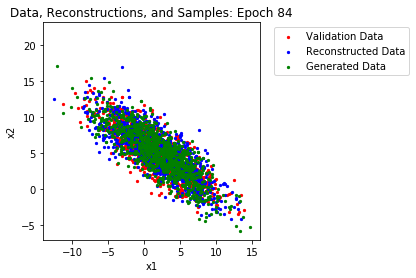

Epoch 85 Average Validation Loss: 6.8222


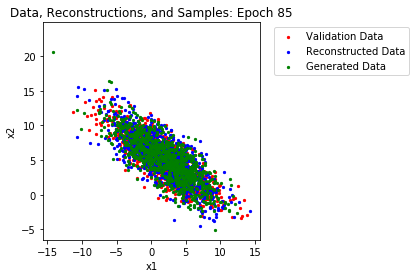

Epoch 86 Average Validation Loss: 6.8544


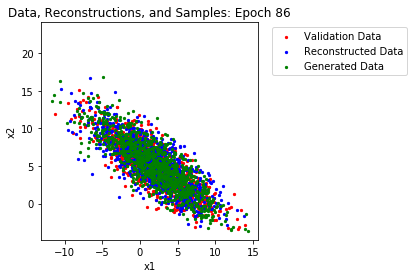

Epoch 87 Average Validation Loss: 6.7993


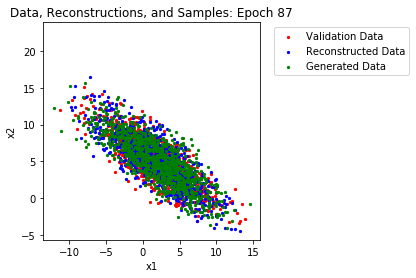

Epoch 88 Average Validation Loss: 6.8684


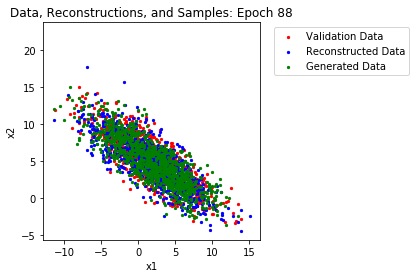

Epoch 89 Average Validation Loss: 6.9147


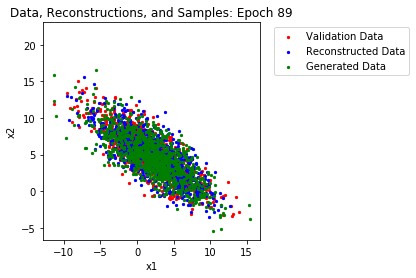

Epoch 90 Average Validation Loss: 6.8296


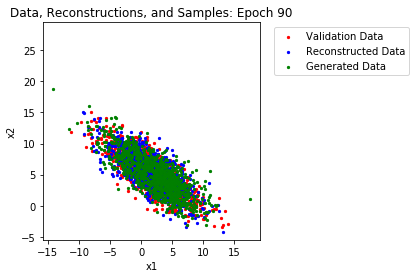

Epoch 91 Average Validation Loss: 6.8285


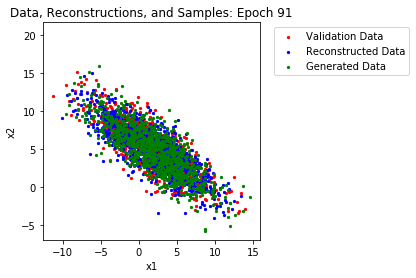

Epoch 92 Average Validation Loss: 6.8217


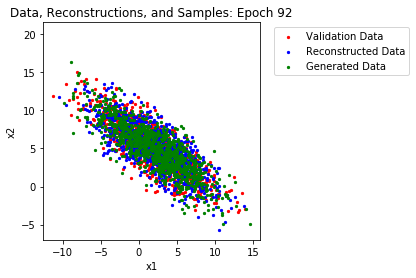

Epoch 93 Average Validation Loss: 6.8299


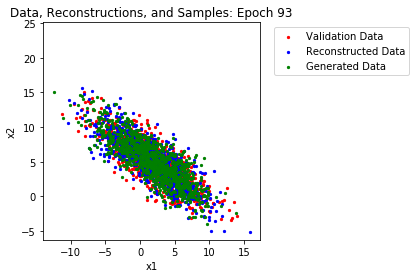

Epoch 94 Average Validation Loss: 6.8056


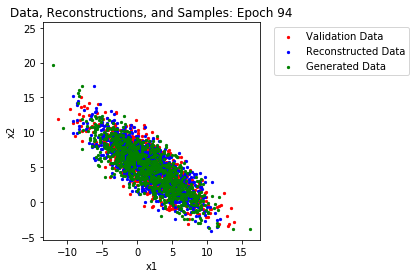

Epoch 95 Average Validation Loss: 6.8215


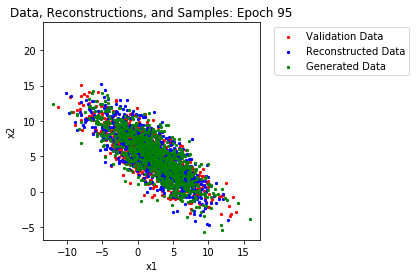

Epoch 96 Average Validation Loss: 6.9095


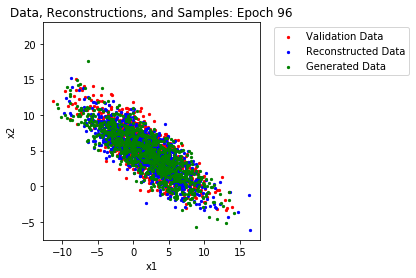

Epoch 97 Average Validation Loss: 6.8661


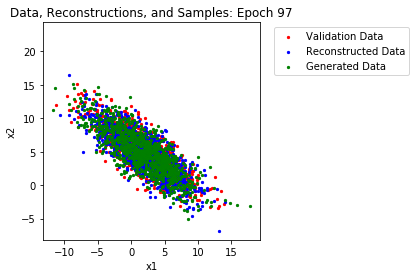

Epoch 98 Average Validation Loss: 6.8762


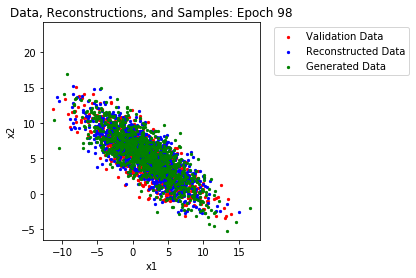

Epoch 99 Average Validation Loss: 6.8850


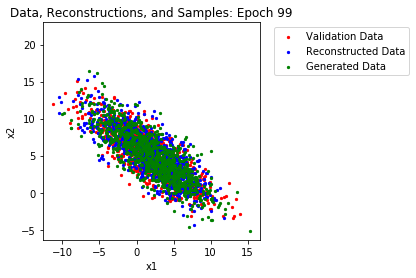

Epoch 100 Average Validation Loss: 6.9189


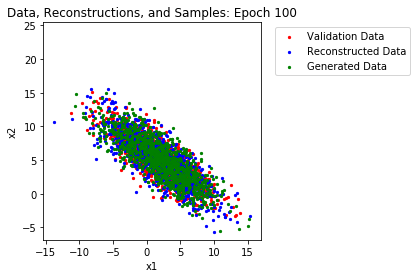

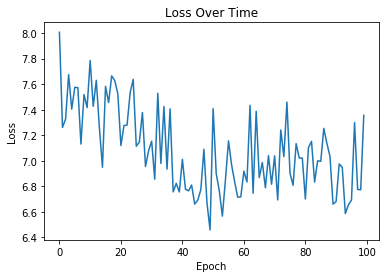

In [12]:
eval(model_list_ex1, loss_list_ex1, valid_loader_ex1, optimizer_ex1)

## 4. Example 2: Learning Two Multivariate Gaussians

The previous example was fairly trivial. Let's see if we can take it further and learn a data distribution which is composed of two independent modes, each a multivariate Gaussian.

### 4.1 Generating Data

In [13]:
# dataset statistics
obs_dim = 2
mu_data_1 = torch.Tensor([2.0, 5.0])
cov_data_1 = torch.Tensor(
    [[15.0, -10.0],
     [-10.0, 10.0]]
)
L_data_1 = torch.cholesky(cov_data_1)

mu_data_2 = torch.Tensor([18.0, 20.0])
cov_data_2 = torch.Tensor(
    [[5.0, -3.0],
     [-3.0, 20.0]]
)
L_data_2 = torch.cholesky(cov_data_2)

# generating training and validation sets
num_train_pts = 10000
num_valid_pts = 1000

eps_train_1 = torch.randn(2, num_train_pts // 2)
eps_train_2 = torch.randn(2, num_train_pts // 2)
eps_valid_1 = torch.randn(2, num_valid_pts // 2)
eps_valid_2 = torch.randn(2, num_valid_pts // 2)

train_data_1 = mu_data_1 + (L_data_1 @ eps_train_1).transpose(-1, -2)
train_data_2 = mu_data_2 + (L_data_2 @ eps_train_2).transpose(-1, -2)
valid_data_1 = mu_data_1 + (L_data_1 @ eps_valid_1).transpose(-1, -2)
valid_data_2 = mu_data_2 + (L_data_2 @ eps_valid_2).transpose(-1, -2)

train_data_ex2 = torch.cat([train_data_1, train_data_2], dim=0)
valid_data_ex2 = torch.cat([valid_data_1, valid_data_2], dim=0)

### 4.2 Training Settings

In [14]:
# hyperparameters
latent_dim = 2
batch_size = 32
epochs = 100
lr = 1e-3  # initial learning rate
step_size = 10  # steps per decay for lr scheduler
gamma = 0.9  # multiplicative decay for lr scheduler

In [15]:
# preparing dataloaders, optimizer, and scheduler
model_ex2 = VAE1(latent_dim, obs_dim)
train_loader_ex2 = torch.utils.data.DataLoader(
    train_data_ex2,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
valid_loader_ex2 = torch.utils.data.DataLoader(
    valid_data_ex2,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
optimizer_ex2 = optim.Adam(model_ex2.parameters(), lr=lr)
scheduler_ex2 = optim.lr_scheduler.StepLR(optimizer=optimizer_ex2, step_size=step_size, gamma=gamma)

### 4.3 Training

In [16]:
model_list_ex2, loss_list_ex2 = train(
    model_ex2,
    epochs,
    train_loader_ex2,
    optimizer_ex2,
    scheduler=scheduler_ex2
)

Epoch: 1	Iteration: 10	Loss: 128.6100
Epoch: 1	Iteration: 20	Loss: 129.9606
Epoch: 1	Iteration: 30	Loss: 127.8947
Epoch: 1	Iteration: 40	Loss: 52.8247
Epoch: 1	Iteration: 50	Loss: 36.7298
Epoch: 1	Iteration: 60	Loss: 36.0648
Epoch: 1	Iteration: 70	Loss: 26.5618
Epoch: 1	Iteration: 80	Loss: 21.6089
Epoch: 1	Iteration: 90	Loss: 16.2491
Epoch: 1	Iteration: 100	Loss: 13.9941
Epoch: 1	Iteration: 110	Loss: 15.3833
Epoch: 1	Iteration: 120	Loss: 13.9028
Epoch: 1	Iteration: 130	Loss: 15.1412
Epoch: 1	Iteration: 140	Loss: 14.2824
Epoch: 1	Iteration: 150	Loss: 12.8863
Epoch: 1	Iteration: 160	Loss: 14.3554
Epoch: 1	Iteration: 170	Loss: 11.9932
Epoch: 1	Iteration: 180	Loss: 12.2022
Epoch: 1	Iteration: 190	Loss: 12.0650
Epoch: 1	Iteration: 200	Loss: 11.4531
Epoch: 1	Iteration: 210	Loss: 11.6293
Epoch: 1	Iteration: 220	Loss: 10.8001
Epoch: 1	Iteration: 230	Loss: 11.3148
Epoch: 1	Iteration: 240	Loss: 12.3234
Epoch: 1	Iteration: 250	Loss: 11.1429
Epoch: 1	Iteration: 260	Loss: 10.0057
Epoch: 1	Iteration

Epoch: 8	Iteration: 2200	Loss: 8.7533
Epoch: 8	Iteration: 2210	Loss: 8.9884
Epoch: 8	Iteration: 2220	Loss: 8.5036
Epoch: 8	Iteration: 2230	Loss: 8.7429
Epoch: 8	Iteration: 2240	Loss: 9.1349
Epoch: 8	Iteration: 2250	Loss: 8.7181
Epoch: 8	Iteration: 2260	Loss: 8.9672
Epoch: 8	Iteration: 2270	Loss: 9.1071
Epoch: 8	Iteration: 2280	Loss: 9.2597
Epoch: 8	Iteration: 2290	Loss: 8.1365
Epoch: 8	Iteration: 2300	Loss: 8.5871
Epoch: 8	Iteration: 2310	Loss: 8.8098
Epoch: 8	Iteration: 2320	Loss: 8.8178
Epoch: 8	Iteration: 2330	Loss: 9.2078
Epoch: 8	Iteration: 2340	Loss: 8.6523
Epoch: 8	Iteration: 2350	Loss: 8.9500
Epoch: 8	Iteration: 2360	Loss: 8.8258
Epoch: 8	Iteration: 2370	Loss: 8.2760
Epoch: 8	Iteration: 2380	Loss: 8.6476
Epoch: 8	Iteration: 2390	Loss: 9.1211
Epoch: 8	Iteration: 2400	Loss: 8.4555
Epoch: 8	Iteration: 2410	Loss: 8.6794
Epoch: 8	Iteration: 2420	Loss: 8.6807
Epoch: 8	Iteration: 2430	Loss: 8.8475
Epoch: 8	Iteration: 2440	Loss: 8.7684
Epoch: 8	Iteration: 2450	Loss: 8.3750
Epoch: 8	Ite

Epoch: 14	Iteration: 4350	Loss: 8.2740
Epoch: 14	Iteration: 4360	Loss: 8.2931
Epoch: 15	Iteration: 4370	Loss: 8.1313
Epoch: 15	Iteration: 4380	Loss: 8.4295
Epoch: 15	Iteration: 4390	Loss: 8.5305
Epoch: 15	Iteration: 4400	Loss: 8.7700
Epoch: 15	Iteration: 4410	Loss: 8.0270
Epoch: 15	Iteration: 4420	Loss: 8.0857
Epoch: 15	Iteration: 4430	Loss: 8.6792
Epoch: 15	Iteration: 4440	Loss: 8.0833
Epoch: 15	Iteration: 4450	Loss: 8.3722
Epoch: 15	Iteration: 4460	Loss: 8.0895
Epoch: 15	Iteration: 4470	Loss: 8.1944
Epoch: 15	Iteration: 4480	Loss: 8.2750
Epoch: 15	Iteration: 4490	Loss: 8.1399
Epoch: 15	Iteration: 4500	Loss: 8.0730
Epoch: 15	Iteration: 4510	Loss: 8.5926
Epoch: 15	Iteration: 4520	Loss: 8.3747
Epoch: 15	Iteration: 4530	Loss: 7.7940
Epoch: 15	Iteration: 4540	Loss: 8.3366
Epoch: 15	Iteration: 4550	Loss: 8.3507
Epoch: 15	Iteration: 4560	Loss: 8.3379
Epoch: 15	Iteration: 4570	Loss: 8.0966
Epoch: 15	Iteration: 4580	Loss: 8.3339
Epoch: 15	Iteration: 4590	Loss: 8.2262
Epoch: 15	Iteration: 4600

Epoch: 21	Iteration: 6510	Loss: 8.1252
Epoch: 21	Iteration: 6520	Loss: 8.2811
Epoch: 21	Iteration: 6530	Loss: 8.1068
Epoch: 21	Iteration: 6540	Loss: 8.0111
Epoch: 21	Iteration: 6550	Loss: 8.1264
Epoch: 22	Iteration: 6560	Loss: 8.1404
Epoch: 22	Iteration: 6570	Loss: 8.3970
Epoch: 22	Iteration: 6580	Loss: 8.5534
Epoch: 22	Iteration: 6590	Loss: 8.3622
Epoch: 22	Iteration: 6600	Loss: 8.3722
Epoch: 22	Iteration: 6610	Loss: 8.0363
Epoch: 22	Iteration: 6620	Loss: 8.0476
Epoch: 22	Iteration: 6630	Loss: 7.9610
Epoch: 22	Iteration: 6640	Loss: 8.5275
Epoch: 22	Iteration: 6650	Loss: 7.8767
Epoch: 22	Iteration: 6660	Loss: 7.6909
Epoch: 22	Iteration: 6670	Loss: 8.0813
Epoch: 22	Iteration: 6680	Loss: 8.0183
Epoch: 22	Iteration: 6690	Loss: 8.6580
Epoch: 22	Iteration: 6700	Loss: 7.9295
Epoch: 22	Iteration: 6710	Loss: 8.4422
Epoch: 22	Iteration: 6720	Loss: 9.0943
Epoch: 22	Iteration: 6730	Loss: 8.3356
Epoch: 22	Iteration: 6740	Loss: 8.1236
Epoch: 22	Iteration: 6750	Loss: 7.7979
Epoch: 22	Iteration: 6760

Epoch: 28	Iteration: 8650	Loss: 7.6383
Epoch: 28	Iteration: 8660	Loss: 7.9608
Epoch: 28	Iteration: 8670	Loss: 8.1888
Epoch: 28	Iteration: 8680	Loss: 7.8762
Epoch: 28	Iteration: 8690	Loss: 8.6855
Epoch: 28	Iteration: 8700	Loss: 7.9138
Epoch: 28	Iteration: 8710	Loss: 8.0375
Epoch: 28	Iteration: 8720	Loss: 7.6991
Epoch: 28	Iteration: 8730	Loss: 8.1711
Epoch: 29	Iteration: 8740	Loss: 7.9548
Epoch: 29	Iteration: 8750	Loss: 8.1411
Epoch: 29	Iteration: 8760	Loss: 7.8600
Epoch: 29	Iteration: 8770	Loss: 8.3747
Epoch: 29	Iteration: 8780	Loss: 8.1808
Epoch: 29	Iteration: 8790	Loss: 7.6965
Epoch: 29	Iteration: 8800	Loss: 7.9111
Epoch: 29	Iteration: 8810	Loss: 8.2367
Epoch: 29	Iteration: 8820	Loss: 8.2929
Epoch: 29	Iteration: 8830	Loss: 7.8357
Epoch: 29	Iteration: 8840	Loss: 7.7583
Epoch: 29	Iteration: 8850	Loss: 8.2236
Epoch: 29	Iteration: 8860	Loss: 7.9074
Epoch: 29	Iteration: 8870	Loss: 8.0664
Epoch: 29	Iteration: 8880	Loss: 8.2461
Epoch: 29	Iteration: 8890	Loss: 7.8882
Epoch: 29	Iteration: 8900

Epoch: 35	Iteration: 10770	Loss: 8.3428
Epoch: 35	Iteration: 10780	Loss: 7.9361
Epoch: 35	Iteration: 10790	Loss: 8.0633
Epoch: 35	Iteration: 10800	Loss: 8.0498
Epoch: 35	Iteration: 10810	Loss: 8.0782
Epoch: 35	Iteration: 10820	Loss: 7.7920
Epoch: 35	Iteration: 10830	Loss: 8.0956
Epoch: 35	Iteration: 10840	Loss: 8.0491
Epoch: 35	Iteration: 10850	Loss: 7.8873
Epoch: 35	Iteration: 10860	Loss: 8.5680
Epoch: 35	Iteration: 10870	Loss: 8.1683
Epoch: 35	Iteration: 10880	Loss: 7.8396
Epoch: 35	Iteration: 10890	Loss: 8.1110
Epoch: 35	Iteration: 10900	Loss: 8.2529
Epoch: 35	Iteration: 10910	Loss: 8.1119
Epoch: 35	Iteration: 10920	Loss: 8.0800
Epoch: 36	Iteration: 10930	Loss: 8.2154
Epoch: 36	Iteration: 10940	Loss: 8.3265
Epoch: 36	Iteration: 10950	Loss: 8.3857
Epoch: 36	Iteration: 10960	Loss: 8.0537
Epoch: 36	Iteration: 10970	Loss: 7.9993
Epoch: 36	Iteration: 10980	Loss: 7.8727
Epoch: 36	Iteration: 10990	Loss: 8.3347
Epoch: 36	Iteration: 11000	Loss: 8.1403
Epoch: 36	Iteration: 11010	Loss: 7.8572


Epoch: 42	Iteration: 12920	Loss: 8.2954
Epoch: 42	Iteration: 12930	Loss: 8.1010
Epoch: 42	Iteration: 12940	Loss: 8.4491
Epoch: 42	Iteration: 12950	Loss: 8.1973
Epoch: 42	Iteration: 12960	Loss: 8.1367
Epoch: 42	Iteration: 12970	Loss: 7.9255
Epoch: 42	Iteration: 12980	Loss: 8.2785
Epoch: 42	Iteration: 12990	Loss: 8.0912
Epoch: 42	Iteration: 13000	Loss: 8.2990
Epoch: 42	Iteration: 13010	Loss: 8.2191
Epoch: 42	Iteration: 13020	Loss: 7.7928
Epoch: 42	Iteration: 13030	Loss: 7.8815
Epoch: 42	Iteration: 13040	Loss: 7.8372
Epoch: 42	Iteration: 13050	Loss: 8.3748
Epoch: 42	Iteration: 13060	Loss: 8.0581
Epoch: 42	Iteration: 13070	Loss: 8.2479
Epoch: 42	Iteration: 13080	Loss: 7.8719
Epoch: 42	Iteration: 13090	Loss: 8.4420
Epoch: 42	Iteration: 13100	Loss: 8.0354
Epoch: 43	Iteration: 13110	Loss: 8.0186
Epoch: 43	Iteration: 13120	Loss: 8.1858
Epoch: 43	Iteration: 13130	Loss: 8.3079
Epoch: 43	Iteration: 13140	Loss: 7.6655
Epoch: 43	Iteration: 13150	Loss: 8.4008
Epoch: 43	Iteration: 13160	Loss: 8.2344


Epoch: 49	Iteration: 15000	Loss: 7.7026
Epoch: 49	Iteration: 15010	Loss: 8.2573
Epoch: 49	Iteration: 15020	Loss: 8.1423
Epoch: 49	Iteration: 15030	Loss: 8.6984
Epoch: 49	Iteration: 15040	Loss: 7.9820
Epoch: 49	Iteration: 15050	Loss: 8.0515
Epoch: 49	Iteration: 15060	Loss: 8.1377
Epoch: 49	Iteration: 15070	Loss: 7.9023
Epoch: 49	Iteration: 15080	Loss: 8.1276
Epoch: 49	Iteration: 15090	Loss: 7.7145
Epoch: 49	Iteration: 15100	Loss: 7.9073
Epoch: 49	Iteration: 15110	Loss: 8.1729
Epoch: 49	Iteration: 15120	Loss: 8.0682
Epoch: 49	Iteration: 15130	Loss: 8.5564
Epoch: 49	Iteration: 15140	Loss: 8.1143
Epoch: 49	Iteration: 15150	Loss: 8.4851
Epoch: 49	Iteration: 15160	Loss: 8.0161
Epoch: 49	Iteration: 15170	Loss: 7.8225
Epoch: 49	Iteration: 15180	Loss: 8.5666
Epoch: 49	Iteration: 15190	Loss: 8.0208
Epoch: 49	Iteration: 15200	Loss: 8.2588
Epoch: 49	Iteration: 15210	Loss: 7.9691
Epoch: 49	Iteration: 15220	Loss: 8.2329
Epoch: 49	Iteration: 15230	Loss: 7.9840
Epoch: 49	Iteration: 15240	Loss: 7.9177


Epoch: 55	Iteration: 17060	Loss: 8.2699
Epoch: 55	Iteration: 17070	Loss: 8.9643
Epoch: 55	Iteration: 17080	Loss: 8.1545
Epoch: 55	Iteration: 17090	Loss: 8.3056
Epoch: 55	Iteration: 17100	Loss: 8.2784
Epoch: 55	Iteration: 17110	Loss: 8.0597
Epoch: 55	Iteration: 17120	Loss: 8.3381
Epoch: 55	Iteration: 17130	Loss: 7.7403
Epoch: 55	Iteration: 17140	Loss: 8.2480
Epoch: 55	Iteration: 17150	Loss: 8.1848
Epoch: 55	Iteration: 17160	Loss: 7.9134
Epoch: 56	Iteration: 17170	Loss: 8.0479
Epoch: 56	Iteration: 17180	Loss: 8.3143
Epoch: 56	Iteration: 17190	Loss: 8.2799
Epoch: 56	Iteration: 17200	Loss: 8.5874
Epoch: 56	Iteration: 17210	Loss: 8.0482
Epoch: 56	Iteration: 17220	Loss: 7.9099
Epoch: 56	Iteration: 17230	Loss: 7.8494
Epoch: 56	Iteration: 17240	Loss: 8.0441
Epoch: 56	Iteration: 17250	Loss: 8.0197
Epoch: 56	Iteration: 17260	Loss: 8.3168
Epoch: 56	Iteration: 17270	Loss: 8.2260
Epoch: 56	Iteration: 17280	Loss: 8.0001
Epoch: 56	Iteration: 17290	Loss: 8.1162
Epoch: 56	Iteration: 17300	Loss: 8.1813


Epoch: 62	Iteration: 19140	Loss: 8.1355
Epoch: 62	Iteration: 19150	Loss: 7.7665
Epoch: 62	Iteration: 19160	Loss: 7.7538
Epoch: 62	Iteration: 19170	Loss: 7.6464
Epoch: 62	Iteration: 19180	Loss: 8.1093
Epoch: 62	Iteration: 19190	Loss: 7.8205
Epoch: 62	Iteration: 19200	Loss: 7.9485
Epoch: 62	Iteration: 19210	Loss: 7.9110
Epoch: 62	Iteration: 19220	Loss: 8.1814
Epoch: 62	Iteration: 19230	Loss: 7.9414
Epoch: 62	Iteration: 19240	Loss: 8.1347
Epoch: 62	Iteration: 19250	Loss: 7.8064
Epoch: 62	Iteration: 19260	Loss: 8.0683
Epoch: 62	Iteration: 19270	Loss: 8.0212
Epoch: 62	Iteration: 19280	Loss: 7.7038
Epoch: 62	Iteration: 19290	Loss: 8.7226
Epoch: 62	Iteration: 19300	Loss: 7.8575
Epoch: 62	Iteration: 19310	Loss: 8.2555
Epoch: 62	Iteration: 19320	Loss: 7.9339
Epoch: 62	Iteration: 19330	Loss: 7.9650
Epoch: 62	Iteration: 19340	Loss: 8.0562
Epoch: 63	Iteration: 19350	Loss: 7.9050
Epoch: 63	Iteration: 19360	Loss: 8.1867
Epoch: 63	Iteration: 19370	Loss: 7.8687
Epoch: 63	Iteration: 19380	Loss: 8.1187


Epoch: 69	Iteration: 21250	Loss: 8.0066
Epoch: 69	Iteration: 21260	Loss: 8.1886
Epoch: 69	Iteration: 21270	Loss: 8.0048
Epoch: 69	Iteration: 21280	Loss: 8.1278
Epoch: 69	Iteration: 21290	Loss: 8.2588
Epoch: 69	Iteration: 21300	Loss: 7.9231
Epoch: 69	Iteration: 21310	Loss: 8.3737
Epoch: 69	Iteration: 21320	Loss: 8.2894
Epoch: 69	Iteration: 21330	Loss: 7.9612
Epoch: 69	Iteration: 21340	Loss: 7.6509
Epoch: 69	Iteration: 21350	Loss: 7.4850
Epoch: 69	Iteration: 21360	Loss: 7.8531
Epoch: 69	Iteration: 21370	Loss: 7.9001
Epoch: 69	Iteration: 21380	Loss: 8.4301
Epoch: 69	Iteration: 21390	Loss: 7.6902
Epoch: 69	Iteration: 21400	Loss: 7.9872
Epoch: 69	Iteration: 21410	Loss: 7.6654
Epoch: 69	Iteration: 21420	Loss: 8.0344
Epoch: 69	Iteration: 21430	Loss: 8.4615
Epoch: 69	Iteration: 21440	Loss: 8.1640
Epoch: 69	Iteration: 21450	Loss: 8.0187
Epoch: 69	Iteration: 21460	Loss: 8.5757
Epoch: 69	Iteration: 21470	Loss: 8.5661
Epoch: 69	Iteration: 21480	Loss: 8.3033
Epoch: 69	Iteration: 21490	Loss: 7.6599


Epoch: 75	Iteration: 23400	Loss: 8.3156
Epoch: 76	Iteration: 23410	Loss: 7.7363
Epoch: 76	Iteration: 23420	Loss: 7.9866
Epoch: 76	Iteration: 23430	Loss: 7.7571
Epoch: 76	Iteration: 23440	Loss: 7.8028
Epoch: 76	Iteration: 23450	Loss: 8.2116
Epoch: 76	Iteration: 23460	Loss: 7.8183
Epoch: 76	Iteration: 23470	Loss: 8.2565
Epoch: 76	Iteration: 23480	Loss: 7.8324
Epoch: 76	Iteration: 23490	Loss: 7.8884
Epoch: 76	Iteration: 23500	Loss: 7.5360
Epoch: 76	Iteration: 23510	Loss: 8.1532
Epoch: 76	Iteration: 23520	Loss: 7.7416
Epoch: 76	Iteration: 23530	Loss: 8.3040
Epoch: 76	Iteration: 23540	Loss: 7.8274
Epoch: 76	Iteration: 23550	Loss: 8.5274
Epoch: 76	Iteration: 23560	Loss: 7.9608
Epoch: 76	Iteration: 23570	Loss: 8.2230
Epoch: 76	Iteration: 23580	Loss: 8.0386
Epoch: 76	Iteration: 23590	Loss: 8.0763
Epoch: 76	Iteration: 23600	Loss: 8.1260
Epoch: 76	Iteration: 23610	Loss: 7.6991
Epoch: 76	Iteration: 23620	Loss: 7.6208
Epoch: 76	Iteration: 23630	Loss: 7.4396
Epoch: 76	Iteration: 23640	Loss: 8.5741


Epoch: 82	Iteration: 25530	Loss: 8.0601
Epoch: 82	Iteration: 25540	Loss: 7.7922
Epoch: 82	Iteration: 25550	Loss: 7.7570
Epoch: 82	Iteration: 25560	Loss: 7.9609
Epoch: 82	Iteration: 25570	Loss: 7.7785
Epoch: 82	Iteration: 25580	Loss: 8.7745
Epoch: 83	Iteration: 25590	Loss: 7.7351
Epoch: 83	Iteration: 25600	Loss: 7.7497
Epoch: 83	Iteration: 25610	Loss: 7.8210
Epoch: 83	Iteration: 25620	Loss: 7.4331
Epoch: 83	Iteration: 25630	Loss: 7.7167
Epoch: 83	Iteration: 25640	Loss: 8.1864
Epoch: 83	Iteration: 25650	Loss: 7.9737
Epoch: 83	Iteration: 25660	Loss: 8.2610
Epoch: 83	Iteration: 25670	Loss: 7.7494
Epoch: 83	Iteration: 25680	Loss: 7.9203
Epoch: 83	Iteration: 25690	Loss: 7.9945
Epoch: 83	Iteration: 25700	Loss: 8.2300
Epoch: 83	Iteration: 25710	Loss: 7.7506
Epoch: 83	Iteration: 25720	Loss: 7.9349
Epoch: 83	Iteration: 25730	Loss: 7.5946
Epoch: 83	Iteration: 25740	Loss: 8.0385
Epoch: 83	Iteration: 25750	Loss: 7.8062
Epoch: 83	Iteration: 25760	Loss: 7.6543
Epoch: 83	Iteration: 25770	Loss: 7.9201


Epoch: 89	Iteration: 27670	Loss: 7.9090
Epoch: 89	Iteration: 27680	Loss: 7.8026
Epoch: 89	Iteration: 27690	Loss: 7.8722
Epoch: 89	Iteration: 27700	Loss: 7.9937
Epoch: 89	Iteration: 27710	Loss: 7.6381
Epoch: 89	Iteration: 27720	Loss: 7.8094
Epoch: 89	Iteration: 27730	Loss: 7.9159
Epoch: 89	Iteration: 27740	Loss: 7.9638
Epoch: 89	Iteration: 27750	Loss: 7.6692
Epoch: 89	Iteration: 27760	Loss: 7.3070
Epoch: 90	Iteration: 27770	Loss: 7.4632
Epoch: 90	Iteration: 27780	Loss: 7.8357
Epoch: 90	Iteration: 27790	Loss: 7.7059
Epoch: 90	Iteration: 27800	Loss: 7.9942
Epoch: 90	Iteration: 27810	Loss: 7.9828
Epoch: 90	Iteration: 27820	Loss: 7.7068
Epoch: 90	Iteration: 27830	Loss: 8.1385
Epoch: 90	Iteration: 27840	Loss: 8.0463
Epoch: 90	Iteration: 27850	Loss: 8.0019
Epoch: 90	Iteration: 27860	Loss: 7.6947
Epoch: 90	Iteration: 27870	Loss: 7.4086
Epoch: 90	Iteration: 27880	Loss: 8.0659
Epoch: 90	Iteration: 27890	Loss: 8.1485
Epoch: 90	Iteration: 27900	Loss: 7.6671
Epoch: 90	Iteration: 27910	Loss: 7.5305


Epoch: 96	Iteration: 29730	Loss: 7.7839
Epoch: 96	Iteration: 29740	Loss: 7.6759
Epoch: 96	Iteration: 29750	Loss: 7.8120
Epoch: 96	Iteration: 29760	Loss: 7.7653
Epoch: 96	Iteration: 29770	Loss: 7.6278
Epoch: 96	Iteration: 29780	Loss: 7.6227
Epoch: 96	Iteration: 29790	Loss: 7.9353
Epoch: 96	Iteration: 29800	Loss: 7.5975
Epoch: 96	Iteration: 29810	Loss: 8.1910
Epoch: 96	Iteration: 29820	Loss: 7.5588
Epoch: 96	Iteration: 29830	Loss: 8.2200
Epoch: 96	Iteration: 29840	Loss: 7.7421
Epoch: 96	Iteration: 29850	Loss: 7.8215
Epoch: 96	Iteration: 29860	Loss: 7.9963
Epoch: 96	Iteration: 29870	Loss: 7.8101
Epoch: 96	Iteration: 29880	Loss: 7.7264
Epoch: 96	Iteration: 29890	Loss: 7.7219
Epoch: 96	Iteration: 29900	Loss: 8.0721
Epoch: 96	Iteration: 29910	Loss: 7.9385
Epoch: 96	Iteration: 29920	Loss: 8.0125
Epoch: 96	Iteration: 29930	Loss: 7.7983
Epoch: 96	Iteration: 29940	Loss: 7.8871
Epoch: 96	Iteration: 29950	Loss: 8.3823
Epoch: 97	Iteration: 29960	Loss: 8.0959
Epoch: 97	Iteration: 29970	Loss: 7.8850


### 4.4 Evaluation

After evaluating the models, you can see that it is even able to learn multimodal distributions even though the decoder and encoder are unimodal. How? Recall that we are only modeling *conditional* distributions as unimodal (the encoder and decoder). This means that *given* a particular data point, we can recover an isotropic Gaussian distribution over the latent space, and similarly, *given* a particular latent variable, we can recover an isotropic Gaussian distibution over the data space.

If we draw data from one of the modes, it's likely to map to one of two modes in the latent space. If we draw data from the other mode, it will map to the other mode in the latent space. Similarly, any points drawn from the corresponding modes in latent space will yield the original modes in data space. Below, you can clearly see two distinct latent modes developing. We can see that roughly, the two modes in latent space are axis-aligned (isotropic) and they are in the range of the standard normal Gaussian (near zero-mean and datapoints not extending too far from the mean). This demonstrates the regularizing effect of the standard normal prior.

We also see that it's quite difficult to specifically generate data in one of the modes or the other. We can only sample from the standard normal and decode the noise many times to retrieve two modes overall in the resulting distribution. The CVAE does a good job of addressing this.

Epoch 1 Average Validation Loss: 10.5723


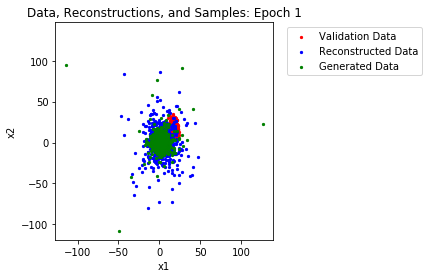

Epoch 2 Average Validation Loss: 9.8283


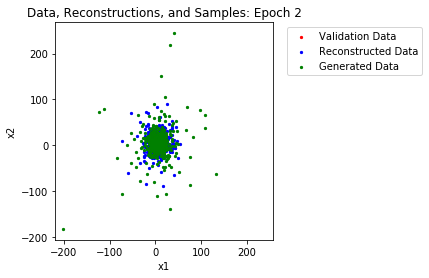

Epoch 3 Average Validation Loss: 9.5846


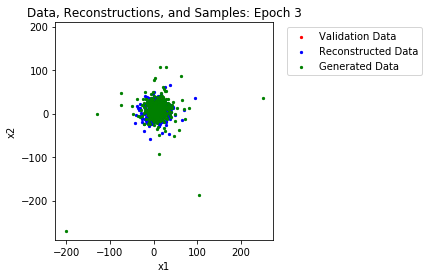

Epoch 4 Average Validation Loss: 9.3161


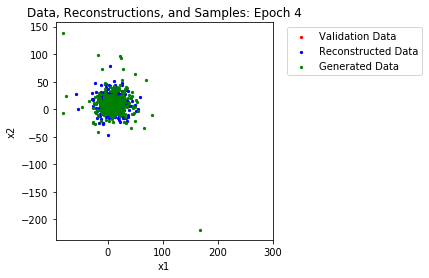

Epoch 5 Average Validation Loss: 9.1881


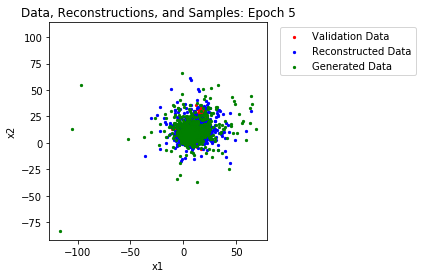

Epoch 6 Average Validation Loss: 9.0551


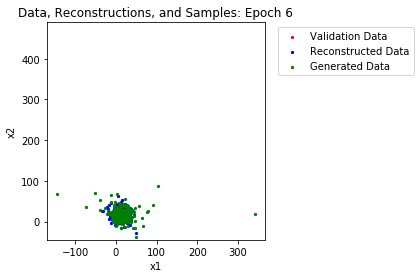

Epoch 7 Average Validation Loss: 8.8638


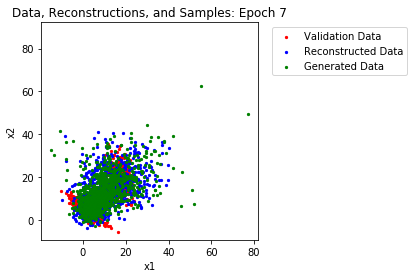

Epoch 8 Average Validation Loss: 8.5537


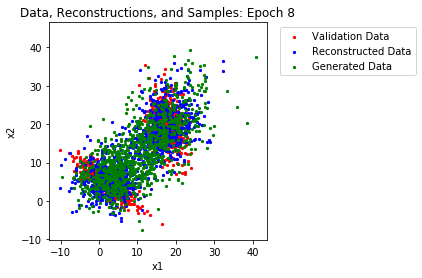

Epoch 9 Average Validation Loss: 8.5419


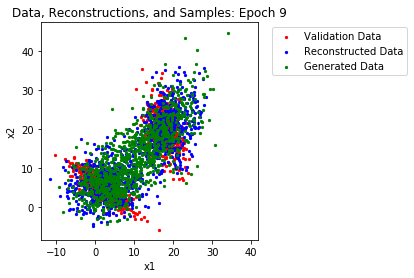

Epoch 10 Average Validation Loss: 8.4070


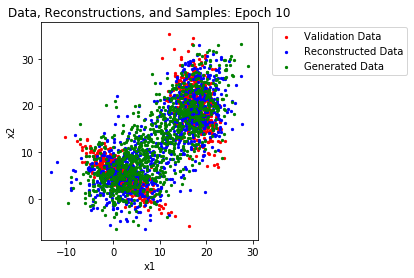

Epoch 11 Average Validation Loss: 8.3434


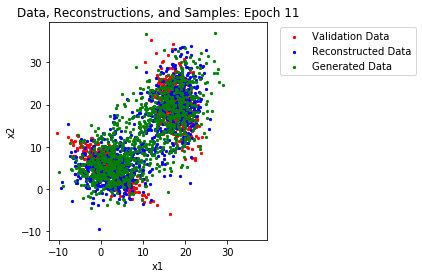

Epoch 12 Average Validation Loss: 8.2845


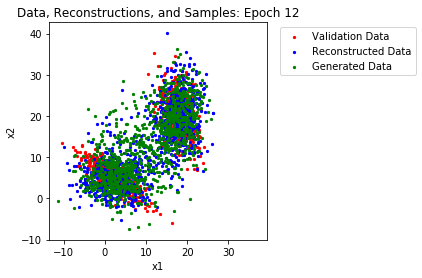

Epoch 13 Average Validation Loss: 8.2376


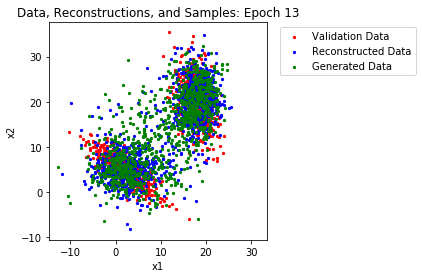

Epoch 14 Average Validation Loss: 8.2202


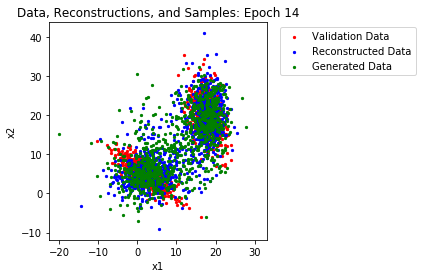

Epoch 15 Average Validation Loss: 8.1616


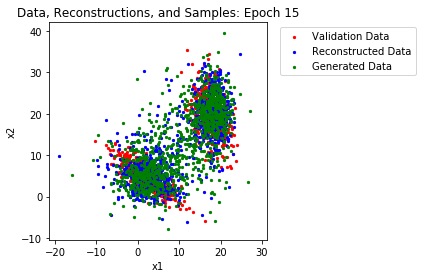

Epoch 16 Average Validation Loss: 8.2485


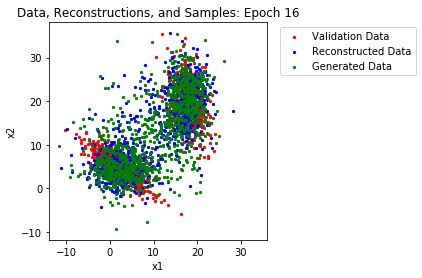

Epoch 17 Average Validation Loss: 8.1841


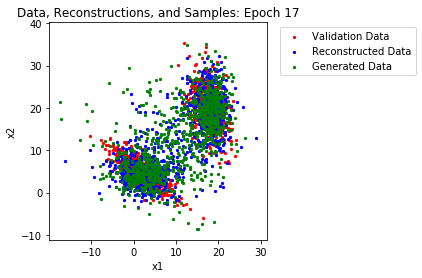

Epoch 18 Average Validation Loss: 8.2253


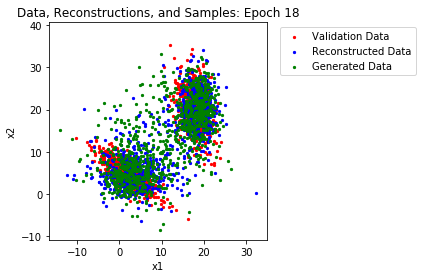

Epoch 19 Average Validation Loss: 8.1658


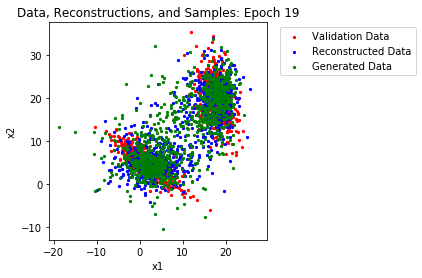

Epoch 20 Average Validation Loss: 8.1434


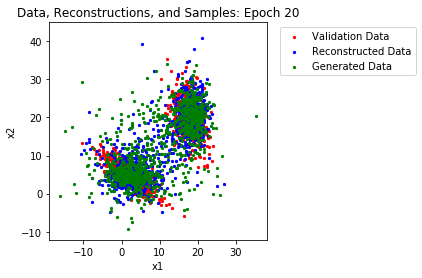

Epoch 21 Average Validation Loss: 8.1941


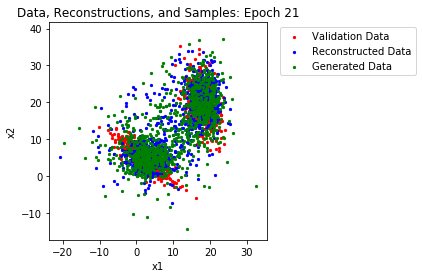

Epoch 22 Average Validation Loss: 8.1343


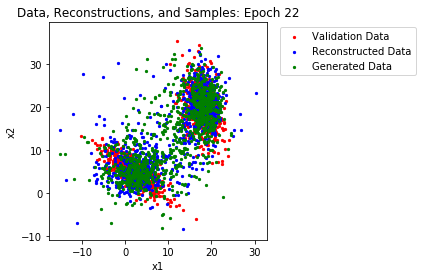

Epoch 23 Average Validation Loss: 8.1114


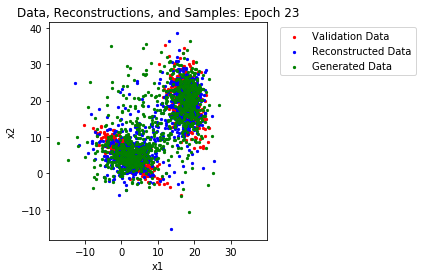

Epoch 24 Average Validation Loss: 8.1517


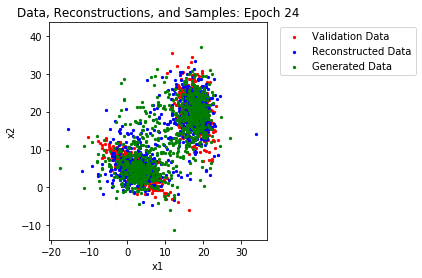

Epoch 25 Average Validation Loss: 8.1783


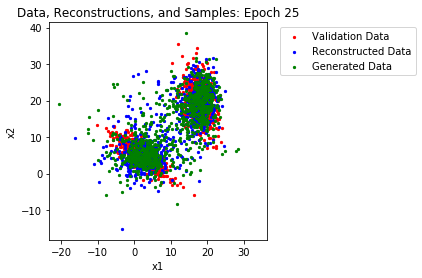

Epoch 26 Average Validation Loss: 8.1236


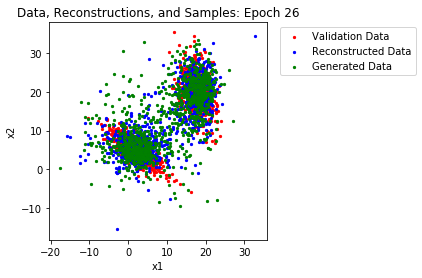

Epoch 27 Average Validation Loss: 8.0832


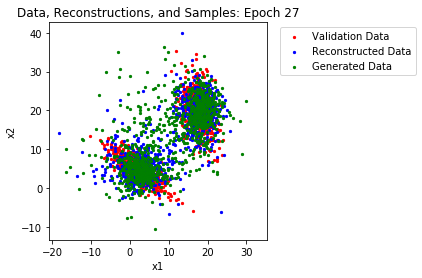

Epoch 28 Average Validation Loss: 8.0641


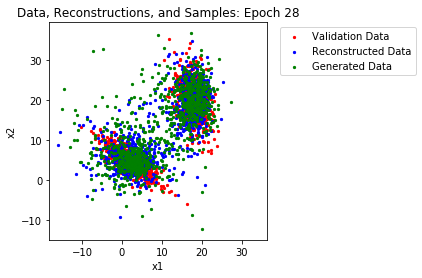

Epoch 29 Average Validation Loss: 8.1791


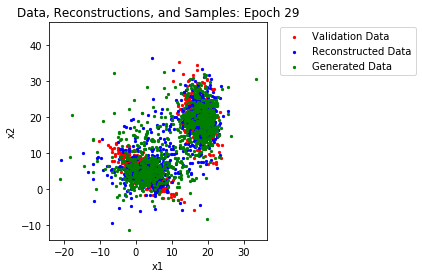

Epoch 30 Average Validation Loss: 8.0565


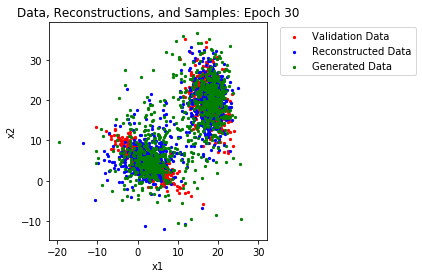

Epoch 31 Average Validation Loss: 8.0985


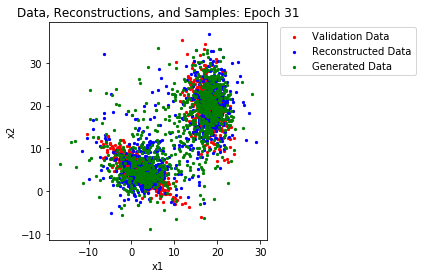

Epoch 32 Average Validation Loss: 8.1266


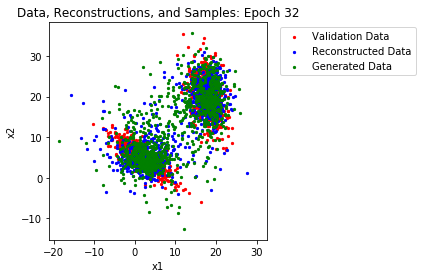

Epoch 33 Average Validation Loss: 8.1749


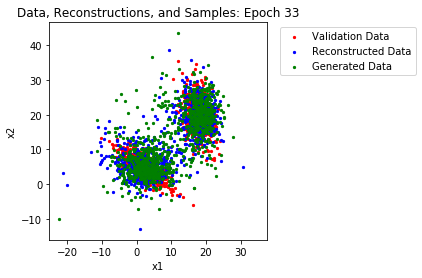

Epoch 34 Average Validation Loss: 8.0746


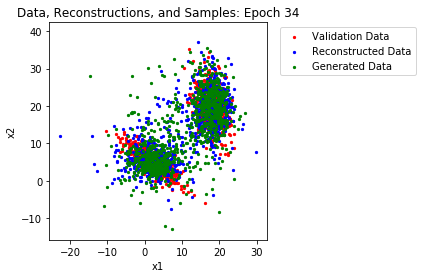

Epoch 35 Average Validation Loss: 8.0820


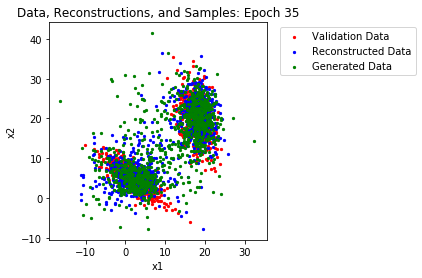

Epoch 36 Average Validation Loss: 8.0679


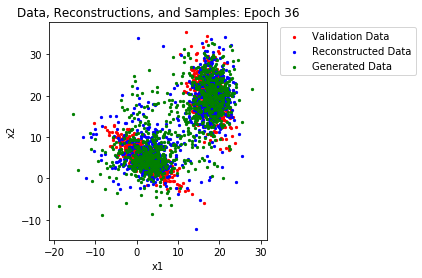

Epoch 37 Average Validation Loss: 8.0842


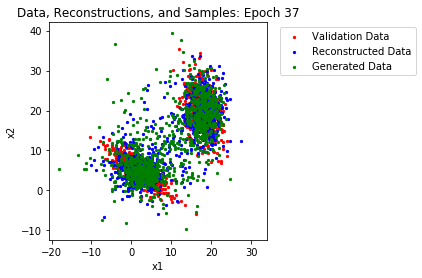

Epoch 38 Average Validation Loss: 8.1050


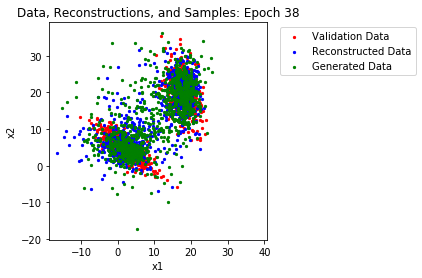

Epoch 39 Average Validation Loss: 8.0837


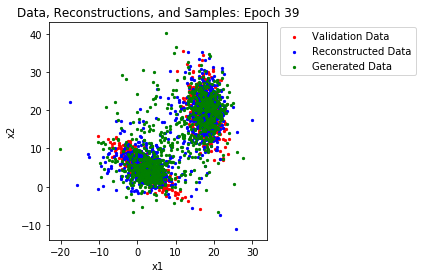

Epoch 40 Average Validation Loss: 8.0712


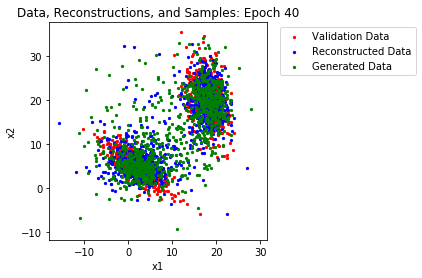

Epoch 41 Average Validation Loss: 8.0602


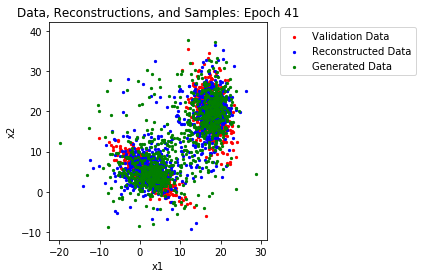

Epoch 42 Average Validation Loss: 8.0622


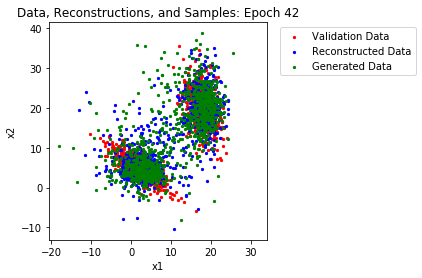

Epoch 43 Average Validation Loss: 8.0748


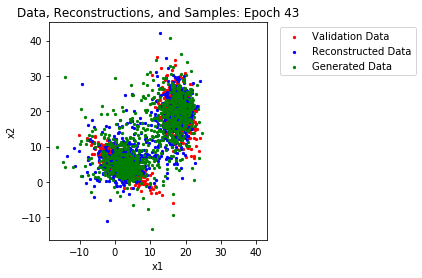

Epoch 44 Average Validation Loss: 8.1210


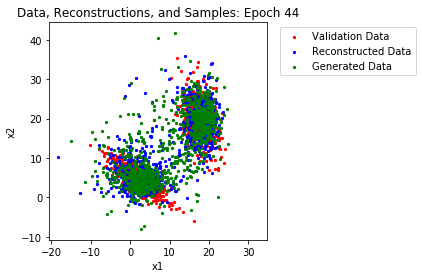

Epoch 45 Average Validation Loss: 8.0931


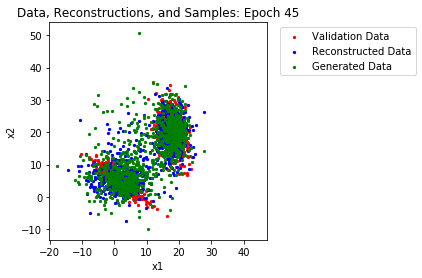

Epoch 46 Average Validation Loss: 8.0973


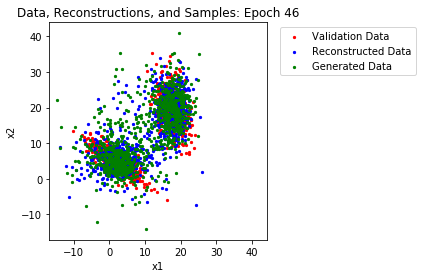

Epoch 47 Average Validation Loss: 8.0564


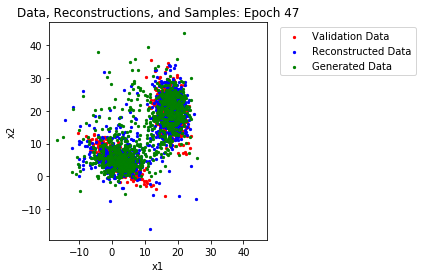

Epoch 48 Average Validation Loss: 8.1067


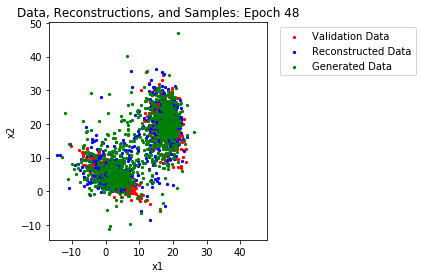

Epoch 49 Average Validation Loss: 8.0402


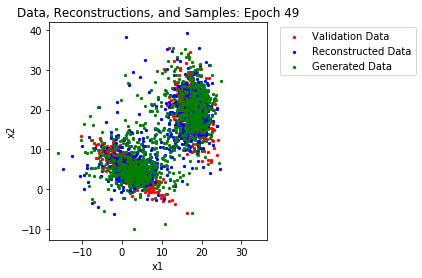

Epoch 50 Average Validation Loss: 8.0602


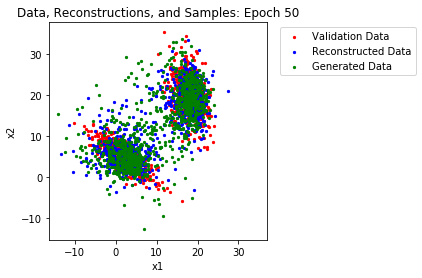

Epoch 51 Average Validation Loss: 8.0080


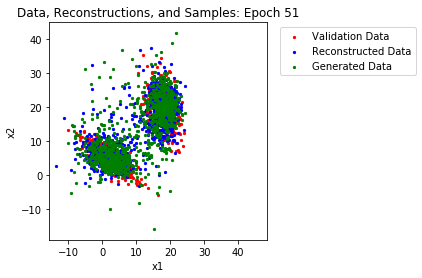

Epoch 52 Average Validation Loss: 8.0706


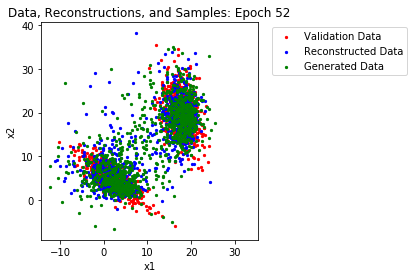

Epoch 53 Average Validation Loss: 8.0648


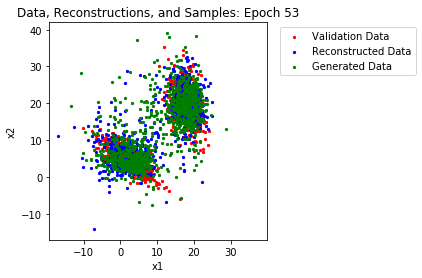

Epoch 54 Average Validation Loss: 8.0144


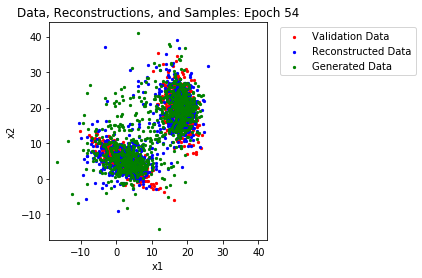

Epoch 55 Average Validation Loss: 8.0529


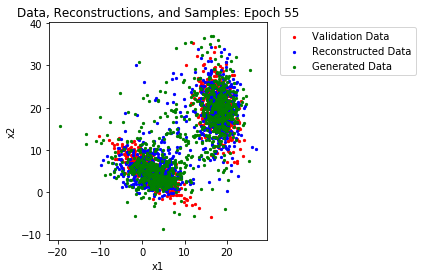

Epoch 56 Average Validation Loss: 8.0868


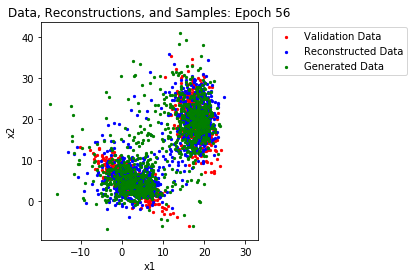

Epoch 57 Average Validation Loss: 8.0935


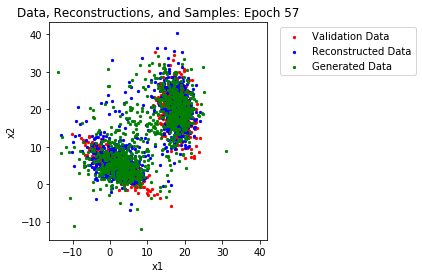

Epoch 58 Average Validation Loss: 8.0705


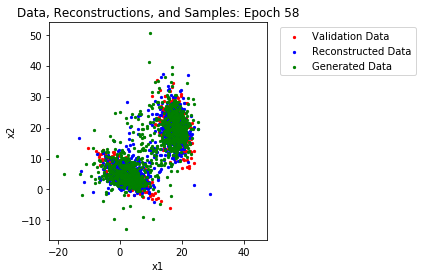

Epoch 59 Average Validation Loss: 8.0320


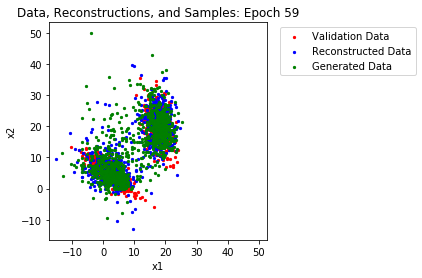

Epoch 60 Average Validation Loss: 8.0310


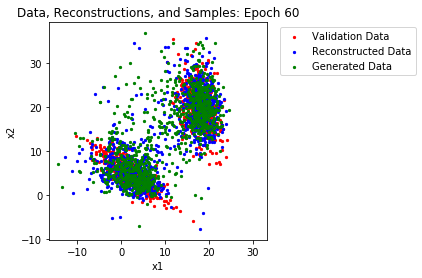

Epoch 61 Average Validation Loss: 8.1090


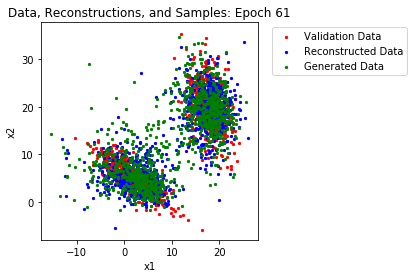

Epoch 62 Average Validation Loss: 8.0333


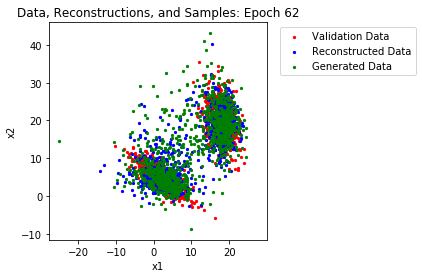

Epoch 63 Average Validation Loss: 7.9545


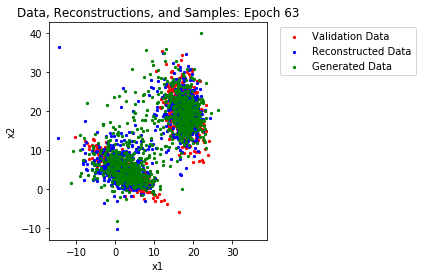

Epoch 64 Average Validation Loss: 8.0279


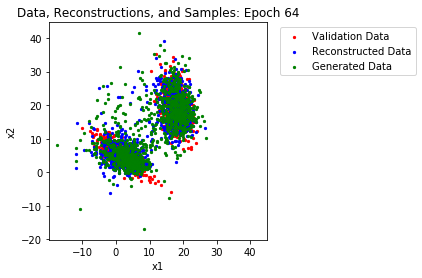

Epoch 65 Average Validation Loss: 7.9724


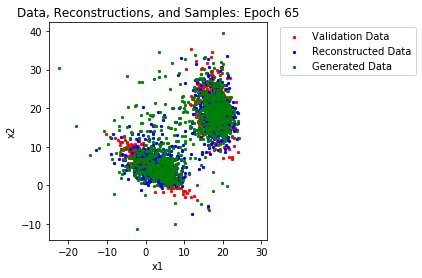

Epoch 66 Average Validation Loss: 8.0069


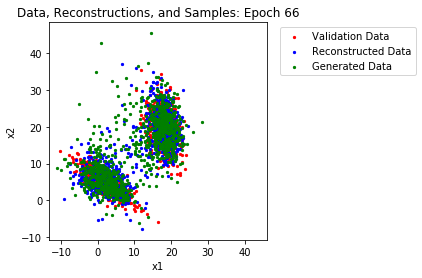

Epoch 67 Average Validation Loss: 7.9834


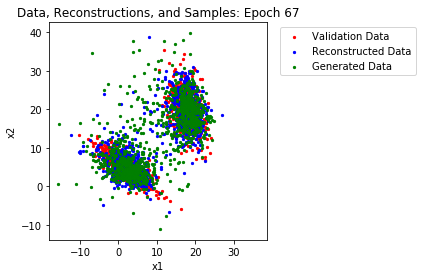

Epoch 68 Average Validation Loss: 8.0298


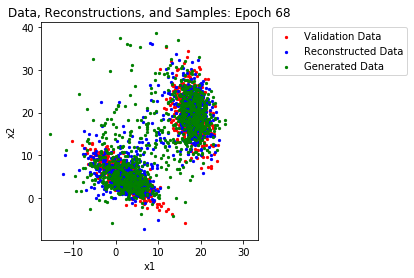

Epoch 69 Average Validation Loss: 7.9335


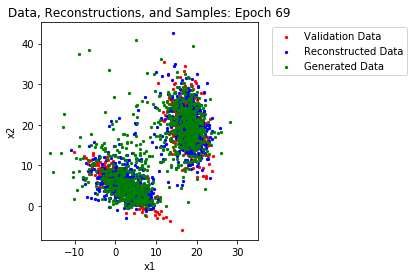

Epoch 70 Average Validation Loss: 8.0061


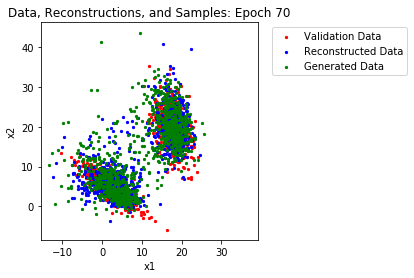

Epoch 71 Average Validation Loss: 7.9643


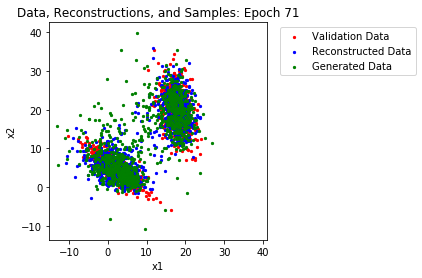

Epoch 72 Average Validation Loss: 8.0008


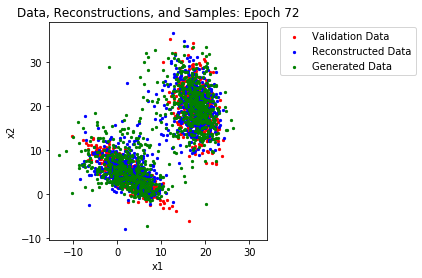

Epoch 73 Average Validation Loss: 7.9583


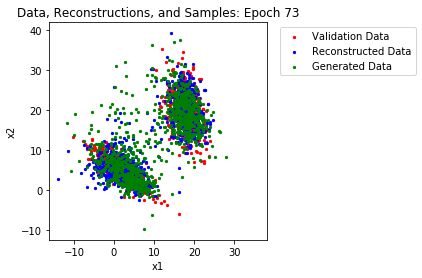

Epoch 74 Average Validation Loss: 7.9679


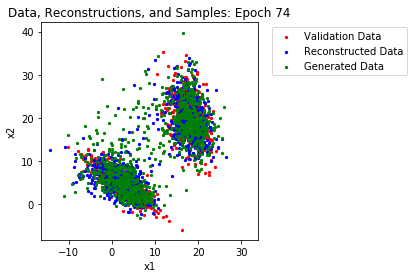

Epoch 75 Average Validation Loss: 7.9557


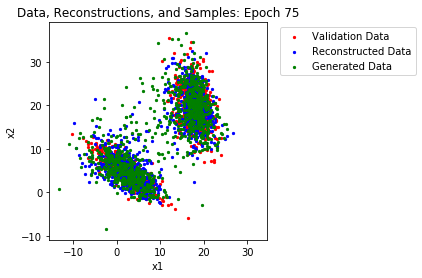

Epoch 76 Average Validation Loss: 7.9387


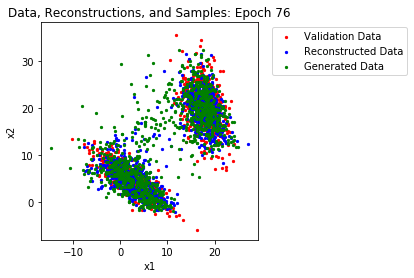

Epoch 77 Average Validation Loss: 7.9095


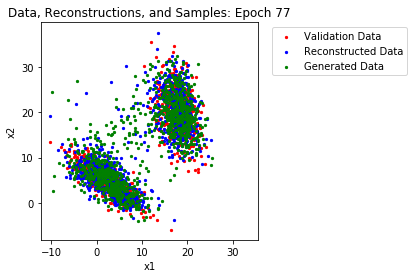

Epoch 78 Average Validation Loss: 7.8703


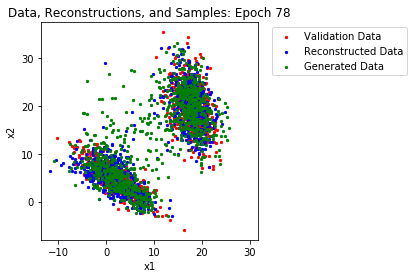

Epoch 79 Average Validation Loss: 7.7962


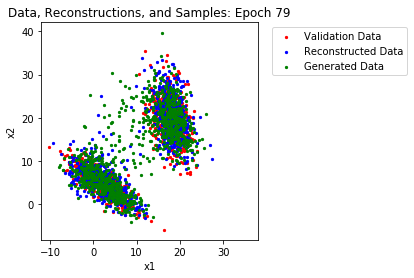

Epoch 80 Average Validation Loss: 7.8469


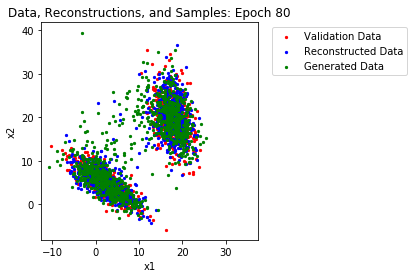

Epoch 81 Average Validation Loss: 7.8470


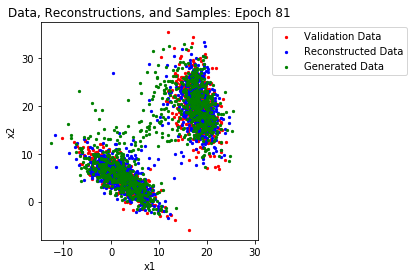

Epoch 82 Average Validation Loss: 7.8561


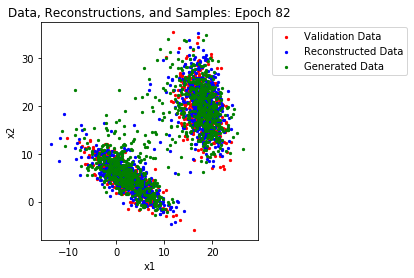

Epoch 83 Average Validation Loss: 7.7648


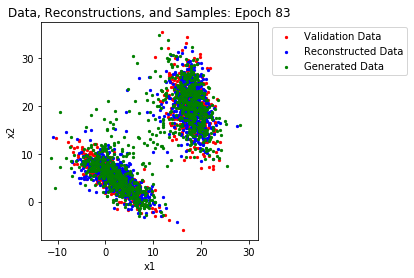

Epoch 84 Average Validation Loss: 7.8576


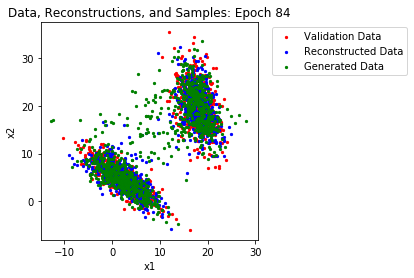

Epoch 85 Average Validation Loss: 7.8867


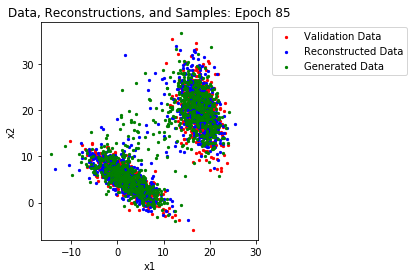

Epoch 86 Average Validation Loss: 7.8714


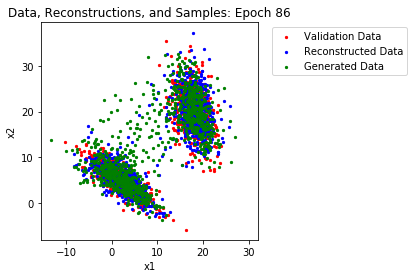

Epoch 87 Average Validation Loss: 7.8874


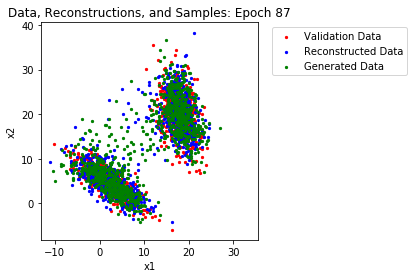

Epoch 88 Average Validation Loss: 7.8985


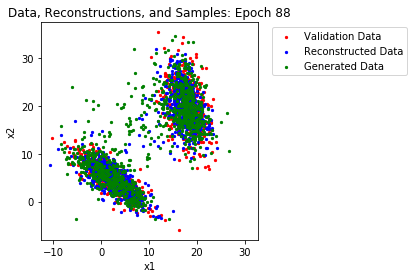

Epoch 89 Average Validation Loss: 7.8600


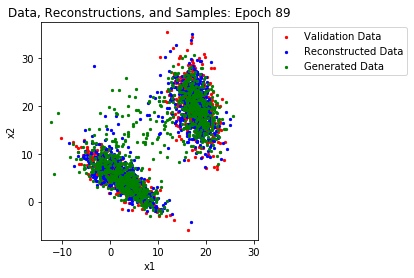

Epoch 90 Average Validation Loss: 7.8042


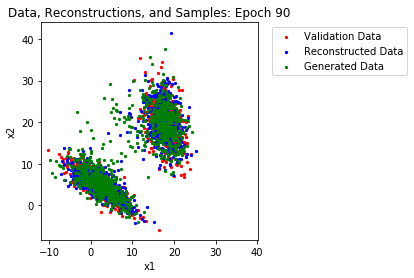

Epoch 91 Average Validation Loss: 7.8007


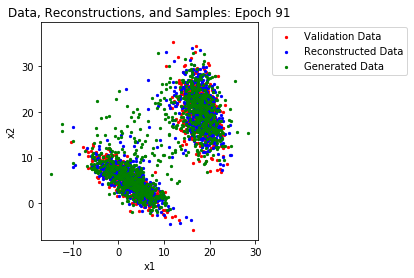

Epoch 92 Average Validation Loss: 7.8378


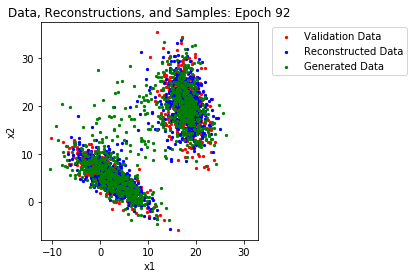

Epoch 93 Average Validation Loss: 7.8492


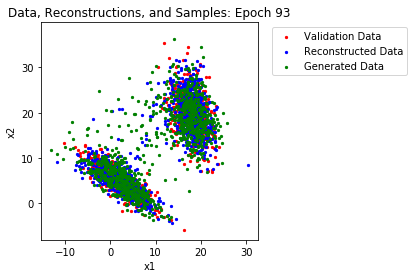

Epoch 94 Average Validation Loss: 7.8414


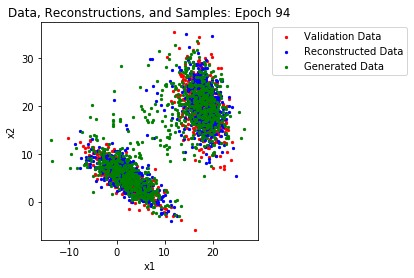

Epoch 95 Average Validation Loss: 7.7997


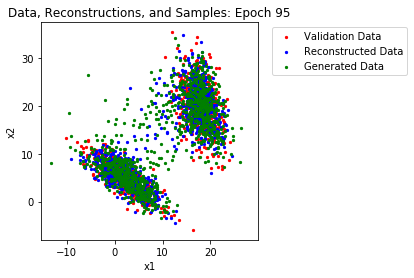

Epoch 96 Average Validation Loss: 7.8691


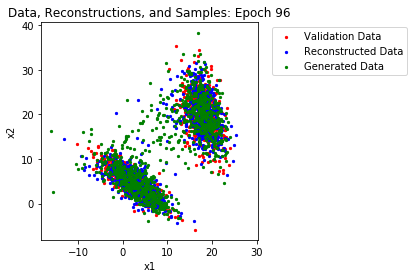

Epoch 97 Average Validation Loss: 7.7729


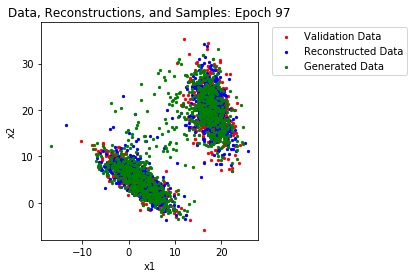

Epoch 98 Average Validation Loss: 7.8208


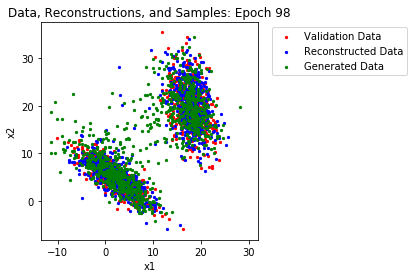

Epoch 99 Average Validation Loss: 7.7677


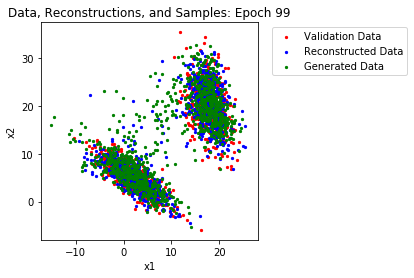

Epoch 100 Average Validation Loss: 7.8002


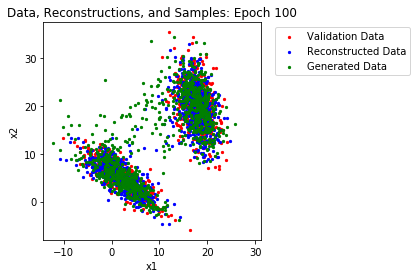

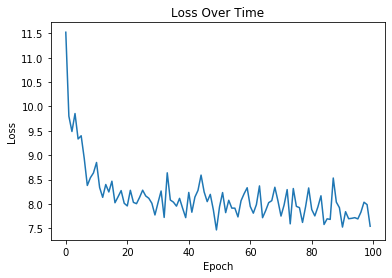

In [17]:
eval(model_list_ex2, loss_list_ex2, valid_loader_ex2, optimizer_ex2)

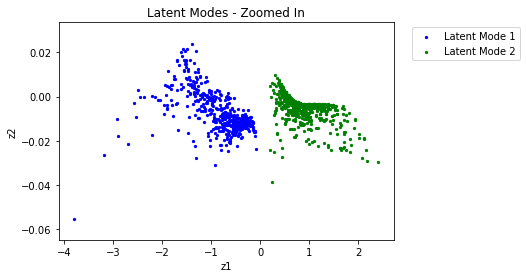

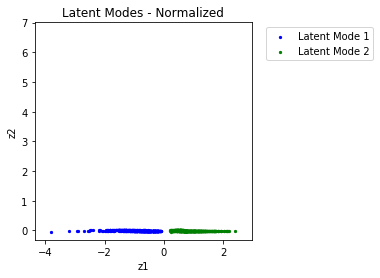

In [18]:
# visualizing the latent space of the final model
final_model_ex2 = model_list_ex2[-1]
latent_data_1 = final_model_ex2._encoder(valid_data_1)  # data from mode 1
latent_data_2 = final_model_ex2._encoder(valid_data_2)  # data from mode 2

# zoomed view
plt.scatter(latent_data_1[:, 0].detach().numpy(), latent_data_1[:, 1].detach().numpy(), c='b', s=5)
plt.scatter(latent_data_2[:, 0].detach().numpy(), latent_data_2[:, 1].detach().numpy(), c='g', s=5)
plt.title("Latent Modes - Zoomed In")
plt.xlabel('z1')
plt.ylabel('z2')
plt.legend(
    ['Latent Mode 1', 'Latent Mode 2'],
    bbox_to_anchor=(1.04,1),
    loc="upper left",
)
plt.show()

# normalized view
plt.scatter(latent_data_1[:, 0].detach().numpy(), latent_data_1[:, 1].detach().numpy(), c='b', s=5)
plt.scatter(latent_data_2[:, 0].detach().numpy(), latent_data_2[:, 1].detach().numpy(), c='g', s=5)
plt.title("Latent Modes - Normalized")
plt.xlabel('z1')
plt.ylabel('z2')
plt.legend(
    ['Latent Mode 1', 'Latent Mode 2'],
    bbox_to_anchor=(1.04,1),
    loc="upper left",
)
ax = plt.gca()
plt.axis('square')
plot_margin = 0.25
x0, x1, y0, y1 = plt.axis()
plt.axis((x0 - plot_margin,
          x1 + plot_margin,
          y0 - plot_margin,
          y1 + plot_margin))
plt.show()

## 5. Example 3: MNIST with VAE

### 5.1 Loading Data

The DOWNLOAD_FLAG flag when set to *True* will download the dataset and the necessary file structure into the directory specified by *data_dir*. Once you do this once, you can set it equal to *False* and it will look in root for the data. If you're reading this, there should be the necessary file structure already with the dataset in it. If there isn't, this lets you generate it.

In [19]:
data_dir = './datasets/'
obs_dim = 784  # MNIST contains 28 x 28 images
DOWNLOAD_FLAG = False

# shape of samples is (B, C, L, L), where B is batch, C is channels=1, L is length=28
train_data_mnist = MNIST(
    root=data_dir,
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_FLAG,
)
valid_data_mnist = MNIST(
    root=data_dir,
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=DOWNLOAD_FLAG,
)

### 5.2 Training Settings

I've set the epochs much higher before than this, but it just takes a very long time to train. I've included a model trained over 50 epochs of data in the ckpts folder, which you can load when generating random samples.

In [20]:
# hyperparameters
latent_dim = 2
batch_size = 32
epochs = 10
lr = 1e-3  # initial learning rate
step_size = 100  # steps per decay for lr scheduler
gamma = 0.95  # multiplicative decay for lr scheduler

In [21]:
# preparing dataloaders, optimizer, and scheduler
model_ex3 = VAE2(latent_dim, obs_dim)
train_loader_ex3 = torch.utils.data.DataLoader(
    train_data_mnist,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
valid_loader_ex3 = torch.utils.data.DataLoader(
    valid_data_mnist,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
optimizer_ex3 = optim.Adam(model_ex3.parameters(), lr=lr)
scheduler_ex3 = optim.lr_scheduler.StepLR(optimizer=optimizer_ex3, step_size=step_size, gamma=gamma)

### 5.3 Training

If you're not tinkering with things specifically, you probably don't want to run the train() block! It takes a lot longer to train a model on data this high-dimensional compared to the extremely low-dimensional data we used before. The first block here just (optionally) selects a model to start training from, useful if you have a checkpoint of a partially trained model. The second block actually trains the model.

In [22]:
# checkpointing
ckpt_path = None  # train from scratch
# ckpt_path = "./ckpts/VAE_MNIST_LOCAL.pth"  # train from saved model

In [23]:
model_list_ex3, loss_list_ex3 = train(
    model_ex3,
    epochs,
    train_loader_ex3,
    optimizer_ex3,
    scheduler=scheduler_ex3,
    vae_type=2,
    print_iter=100,
    ckpt_path=ckpt_path,
)
torch.save(model_list_ex3[-1].state_dict(), './ckpts/VAE_MNIST_LOCAL.pth')

Epoch: 1	Iteration: 100	Loss: 206.8218
Epoch: 1	Iteration: 200	Loss: 183.5679
Epoch: 1	Iteration: 300	Loss: 183.7605
Epoch: 1	Iteration: 400	Loss: 184.3375
Epoch: 1	Iteration: 500	Loss: 175.7846
Epoch: 1	Iteration: 600	Loss: 158.9471
Epoch: 1	Iteration: 700	Loss: 160.0120
Epoch: 1	Iteration: 800	Loss: 157.1001
Epoch: 1	Iteration: 900	Loss: 157.7247
Epoch: 1	Iteration: 1000	Loss: 156.7996
Epoch: 1	Iteration: 1100	Loss: 168.7751
Epoch: 1	Iteration: 1200	Loss: 147.8474
Epoch: 1	Iteration: 1300	Loss: 170.6326
Epoch: 1	Iteration: 1400	Loss: 178.5751
Epoch: 1	Iteration: 1500	Loss: 158.9120
Epoch: 1	Iteration: 1600	Loss: 161.6778
Epoch: 1	Iteration: 1700	Loss: 177.8007
Epoch: 1	Iteration: 1800	Loss: 165.6296
Epoch: 2	Iteration: 1900	Loss: 165.9733
Epoch: 2	Iteration: 2000	Loss: 166.5948
Epoch: 2	Iteration: 2100	Loss: 163.5712
Epoch: 2	Iteration: 2200	Loss: 160.5572
Epoch: 2	Iteration: 2300	Loss: 167.3267
Epoch: 2	Iteration: 2400	Loss: 162.1110
Epoch: 2	Iteration: 2500	Loss: 167.2140
Epoch: 2	

### 5.4 Evaluation

Since the data are 784-dimensional, we can't just plot them to visualize the distribution. However, we can just draw samples from the model at each stage in training to see if it outputs stuff that looks reasonably like images of digits. 

Run the first block to reconstruct the first sample from the validation set at each epoch and also to generate a random sample. You can only run this right after the train() function is called or you won't have the model lists. However, you can still use the generation code below to write something to test reconstruction on the cached model.

Run the second block to sample a random image from the final model. You can run this as many times as you want to generate samples. Observe that every time you run it, a different number will appear. This is because you can't control the conditioning of the sample. Again, CVAEs address this problem.

Run the third block to visualize the latent manifold. To generate this, we sweep through latent values from -3 to 3 on each axis and then pass that through the decoder to see what is generated. Recall that for our specific model, this mapping is deterministic. Code adapted from: https://github.com/ykwon0407/variational_autoencoder/blob/master/variational_bayes.ipynb

Epoch 1 Average Validation Loss: 162.1169
Epoch 2 Average Validation Loss: 155.3288
Epoch 3 Average Validation Loss: 152.3197
Epoch 4 Average Validation Loss: 150.5476
Epoch 5 Average Validation Loss: 148.3428
Epoch 6 Average Validation Loss: 147.4445
Epoch 7 Average Validation Loss: 145.8412
Epoch 8 Average Validation Loss: 145.6305
Epoch 9 Average Validation Loss: 144.7326
Epoch 10 Average Validation Loss: 145.2119


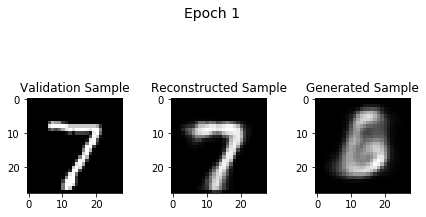

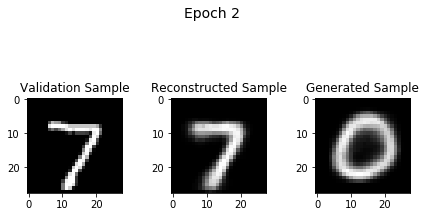

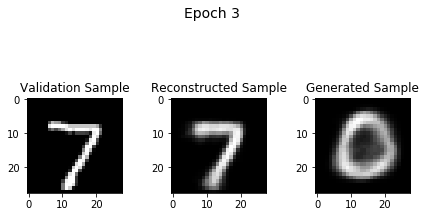

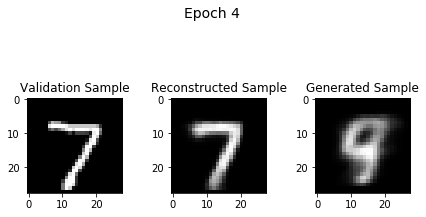

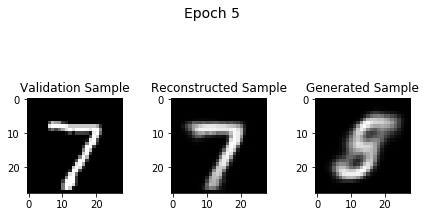

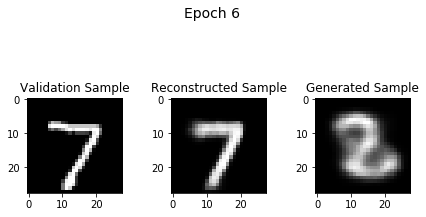

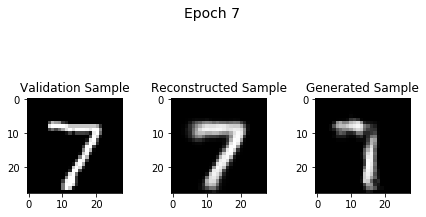

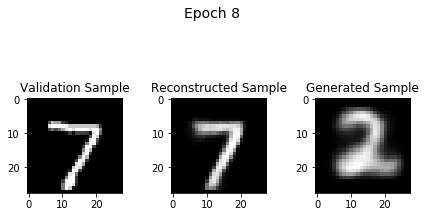

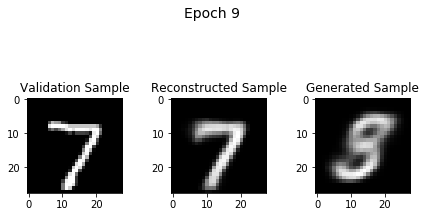

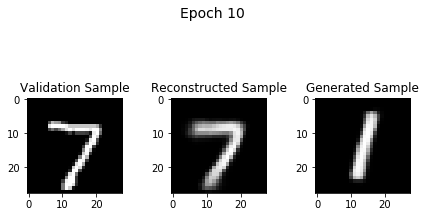

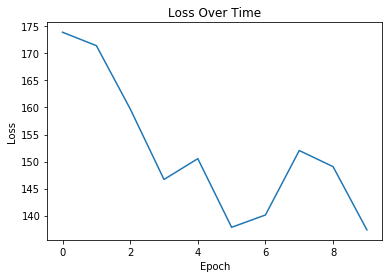

In [39]:
eval(model_list_ex3, loss_list_ex3, valid_loader_ex3, optimizer_ex3, vae_type=2)

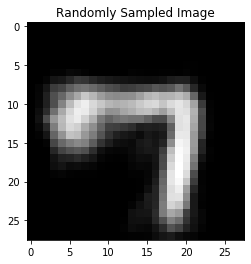

In [70]:
# generate random samples of handwritten numbers
final_model_ex3 = VAE2(2, 784)
final_model_ex3.load_state_dict(torch.load('./ckpts/VAE_MNIST.pth'))  # provided model
img_sample = final_model_ex3.generate(1)
plt.imshow(img_sample.detach(), cmap='gray')
plt.title('Randomly Sampled Image')
plt.show()

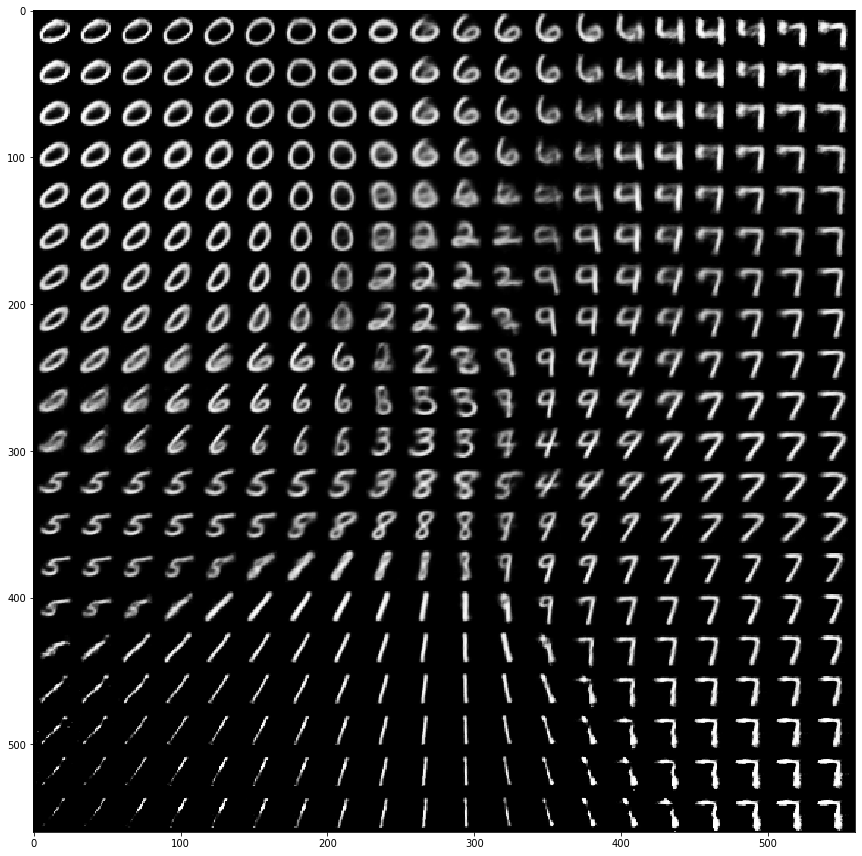

In [46]:
# loading model
final_model_ex3 = VAE2(2, 784)
final_model_ex3.load_state_dict(torch.load('./ckpts/VAE_MNIST.pth'))  # provided model

# initializing latent manifold
num_points = 20
z1_vals = np.linspace(-3, 3, num_points)
z2_vals = np.linspace(-3, 3, num_points)
manifold = np.empty((28 * num_points, 28 * num_points))

# looping through latent values to fill manifold
for i, z1i in enumerate(z1_vals):
    for j, z2j in enumerate(z2_vals):
        z = torch.Tensor([z1i, z2j])
        x_gen_flat = final_model_ex3._decoder(z)
        x_gen = x_gen_flat.reshape(28, 28)
        manifold[
            ((num_points - i - 1) * 28) : ((num_points - i) * 28),
            (j * 28):((j + 1) * 28)
        ] = x_gen.detach()

# plotting
plt.figure(figsize=(12, 12))
plt.imshow(manifold, cmap='gray')
plt.tight_layout()